Universidad del Valle de Guatemala  
Facultad de Ingeniería  
Departamento de Ciencias de la Computación  
CC3085 – Inteligencia Artificial  

Cristian Tunchez (231359)  
Angie Vela (23764)

---

# Proyecto 1: Robot de Navegación con Búsqueda y Redes Neuronales

### Descripción del Escenario

En este proyecto, diseñamos el software de navegación para un robot de entrega. El robot recibe imágenes satelitales (mapas) donde debe encontrar la ruta más eficiente desde un punto A y un punto B.  

El mundo no es binario (pared/camino). Existen diferentes tipos de terreno representados por colores:  

- Áreas **blancas** = caminos libres
- Áreas **negras** = paredes intransitables
- Áreas **verdes** = meta(s)
- Área **roja** = punto de inicio (único)

## Task 1 – Search Engine

El primer paso consiste en construir el **motor de búsqueda** que interpreta una imagen con ciertas características y genera rutas.

---

## Task 1.1 – Discretización del Mundo

En esta sección, representamos la imagen de forma **discreta**. Agrupamos los píxeles en **tiles** (batches) para formar los nodos del grafo.

### Proceso:
1. **Input**: Cargar imagen (.png o .bmp)
2. **Grid**: Discretizar la imagen en una matriz de nodos usando tiles
3. **Identificación**: Encontrar coordenadas de inicio, meta y obstáculos

### 1.1.1 Importación de Librerías

In [86]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from abc import ABC, abstractmethod
from collections import deque
import os

# Configuración de visualización
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

print("Librerías importadas correctamente")

Librerías importadas correctamente


### 1.1.2 Definición de Constantes y Códigos de Terreno

In [62]:
# Códigos numéricos para cada tipo de celda en la matriz discretizada
class TerrainType:
    """Enumeración de tipos de terreno para la discretización del mundo."""
    OBSTACLE = 0    # Negro - Pared/Obstáculo (intransitable)
    PATH = 1        # Blanco - Camino libre
    START = 2       # Rojo - Punto de inicio
    GOAL = 3        # Verde - Meta
    
    @staticmethod
    def get_name(code):
        """Retorna el nombre del tipo de terreno dado su código."""
        names = {
            0: "OBSTACLE (Negro)",
            1: "PATH (Blanco)",
            2: "START (Rojo)",
            3: "GOAL (Verde)"
        }
        return names.get(code, "UNKNOWN")

# Umbrales para clasificación de colores RGB
# Estos valores determinan cómo se clasifica cada píxel según su color
COLOR_THRESHOLDS = {
    'black_max': 50,       # Máximo valor RGB para considerar negro
    'white_min': 200,      # Mínimo valor RGB para considerar blanco
    'red_r_min': 150,      # Mínimo R para rojo
    'red_gb_max': 100,     # Máximo G y B para rojo
    'green_g_min': 150,    # Mínimo G para verde
    'green_rb_max': 100    # Máximo R y B para verde
}

print("[OK] Constantes definidas")
print("\nTipos de terreno:")
for code in [0, 1, 2, 3]:
    print(f"  {code}: {TerrainType.get_name(code)}")

[OK] Constantes definidas

Tipos de terreno:
  0: OBSTACLE (Negro)
  1: PATH (Blanco)
  2: START (Rojo)
  3: GOAL (Verde)


### 1.1.3 Clase WorldDiscretizer

Esta clase encapsula toda la lógica de discretización del mundo. Recibe una imagen y la convierte en una matriz de nodos navegable.

In [87]:
class WorldDiscretizer:
    """
    Clase para discretizar una imagen del mundo en una matriz de nodos.
    
    La imagen se divide en tiles (cuadrículas) de tamaño configurable.
    Cada tile se clasifica según el color predominante de sus píxeles.
    
    Attributes:
        image_path (str): Ruta a la imagen del laberinto
        tile_size (int): Tamaño de cada tile en píxeles (tile_size x tile_size)
        grid (np.ndarray): Matriz discretizada del mundo
        start_pos (tuple): Coordenadas (row, col) del punto de inicio
        goal_positions (list): Lista de coordenadas de las metas
        original_image (np.ndarray): Imagen original como array numpy
    """
    
    def __init__(self, image_path, tile_size=10):
        """
        Inicializa el discretizador con una imagen.
        
        Args:
            image_path (str): Ruta a la imagen (.png o .bmp)
            tile_size (int): Tamaño del tile en píxeles (default: 10)
        """
        self.image_path = image_path
        self.tile_size = tile_size
        self.grid = None
        self.start_pos = None
        self.goal_positions = []
        self.original_image = None
        self.grid_height = 0
        self.grid_width = 0
        
    def load_image(self):
        """
        Carga la imagen desde el archivo especificado.
        
        Returns:
            np.ndarray: Imagen como array RGB
        """
        if not os.path.exists(self.image_path):
            raise FileNotFoundError(f"No se encontró la imagen: {self.image_path}")
        
        # Cargar imagen con Pillow y convertir a RGB
        img = Image.open(self.image_path)
        
        # Convertir a RGB si es necesario (maneja imágenes con canal alfa)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        self.original_image = np.array(img)
        
        print(f"[OK] Imagen cargada: {self.image_path}")
        print(f"  Dimensiones: {self.original_image.shape[1]} x {self.original_image.shape[0]} píxeles")
        print(f"  Canales: {self.original_image.shape[2]}")
        
        return self.original_image
    
    def classify_pixel(self, rgb):
        """
        Clasifica un color RGB en un tipo de terreno.
        
        Args:
            rgb (tuple/array): Valores (R, G, B) del píxel
            
        Returns:
            int: Código del tipo de terreno
        """
        r, g, b = rgb[0], rgb[1], rgb[2]
        th = COLOR_THRESHOLDS
        
        # Negro (Obstáculo) - todos los valores bajos
        if r <= th['black_max'] and g <= th['black_max'] and b <= th['black_max']:
            return TerrainType.OBSTACLE
        
        # Rojo (Inicio) - R alto, G y B bajos
        if r >= th['red_r_min'] and g <= th['red_gb_max'] and b <= th['red_gb_max']:
            return TerrainType.START
        
        # Verde (Meta) - G alto, R y B bajos
        if g >= th['green_g_min'] and r <= th['green_rb_max'] and b <= th['green_rb_max']:
            return TerrainType.GOAL
        
        # Blanco o cualquier otro color (Camino)
        return TerrainType.PATH
    
    def classify_tile(self, tile):
        """
        Clasifica un tile basándose en el color predominante.
        
        Estrategia: 
        - Si hay algún píxel de inicio (rojo), el tile es inicio
        - Si hay algún píxel de meta (verde), el tile es meta
        - Si más del 50% son obstáculos, el tile es obstáculo
        - De lo contrario, es camino
        
        Args:
            tile (np.ndarray): Porción de la imagen (tile_size x tile_size x 3)
            
        Returns:
            int: Código del tipo de terreno para el tile
        """
        # Contar cada tipo de píxel en el tile
        counts = {TerrainType.OBSTACLE: 0, TerrainType.PATH: 0, 
                TerrainType.START: 0, TerrainType.GOAL: 0}
        
        total_pixels = tile.shape[0] * tile.shape[1]
        
        # Clasificar cada píxel
        for i in range(tile.shape[0]):
            for j in range(tile.shape[1]):
                pixel_type = self.classify_pixel(tile[i, j])
                counts[pixel_type] += 1
        
        # Prioridad: START > GOAL > OBSTACLE > PATH
        # Si hay cualquier píxel de inicio, el tile es inicio
        if counts[TerrainType.START] > 0:
            return TerrainType.START
        
        # Si hay cualquier píxel de meta, el tile es meta
        if counts[TerrainType.GOAL] > 0:
            return TerrainType.GOAL
        
        # Si más del 50% son obstáculos, es obstáculo
        if counts[TerrainType.OBSTACLE] > total_pixels * 0.5:
            return TerrainType.OBSTACLE
        
        # Por defecto es camino
        return TerrainType.PATH
    
    def _consolidate_special_tiles(self, terrain_type_code):
        """
        Consolida tiles adyacentes del mismo tipo especial (START o GOAL).
        
        Usa flood fill para encontrar grupos conectados y retorna el centroide de cada grupo.
        
        Args:
            terrain_type_code (int): TerrainType.START o TerrainType.GOAL
            
        Returns:
            list: Lista de posiciones (row, col) consolidadas
        """
        # Encontrar todos los tiles del tipo especificado
        positions_mask = (self.grid == terrain_type_code)
        
        if not positions_mask.any():
            return []
        
        # Crear copia de la máscara para ir marcando tiles visitados
        unvisited = positions_mask.copy()
        clusters = []
        
        def flood_fill(start_row, start_col):
            """Flood fill para encontrar todos los tiles conectados (8-conectividad)."""
            cluster = []
            stack = [(start_row, start_col)]
            
            while stack:
                row, col = stack.pop()
                
                # Verificar límites y si ya fue visitado
                if not (0 <= row < self.grid_height and 
                        0 <= col < self.grid_width):
                    continue
                
                if not unvisited[row, col]:
                    continue
                
                # Marcar como visitado y agregar al cluster
                unvisited[row, col] = False
                cluster.append((row, col))
                
                # Agregar vecinos (8-conectividad)
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue
                        stack.append((row + dr, col + dc))
            
            return cluster
        
        # Encontrar todos los clusters usando flood fill
        for row in range(self.grid_height):
            for col in range(self.grid_width):
                if unvisited[row, col]:
                    cluster = flood_fill(row, col)
                    if cluster:
                        clusters.append(cluster)
        
        # Calcular centroide de cada cluster
        centroids = []
        for cluster in clusters:
            avg_row = sum(pos[0] for pos in cluster) / len(cluster)
            avg_col = sum(pos[1] for pos in cluster) / len(cluster)
            centroids.append((int(round(avg_row)), int(round(avg_col))))
        
        # Información de depuración
        if len(clusters) > 1:
            terrain_name = "START" if terrain_type_code == TerrainType.START else "GOAL"
            print(f"  [INFO] Se encontraron {len(clusters)} grupos de {terrain_name}:")
            for i, (cluster, centroid) in enumerate(zip(clusters, centroids), 1):
                print(f"    Grupo {i}: {len(cluster)} tiles → centroide en {centroid}")
        
        return centroids
    
    def discretize(self):
        """
        Discretiza la imagen en una matriz de nodos.
        
        Divide la imagen en tiles y clasifica cada uno.
        También identifica las posiciones de inicio y meta.
        
        Returns:
            np.ndarray: Matriz discretizada del mundo
        """
        if self.original_image is None:
            self.load_image()
        
        img_height, img_width = self.original_image.shape[:2]
        
        # Calcular dimensiones de la grilla
        self.grid_height = img_height // self.tile_size
        self.grid_width = img_width // self.tile_size
        
        print("\n[OK] Discretizando imagen...")
        print(f"  Tamaño de tile: {self.tile_size}x{self.tile_size} píxeles")
        print(f"  Dimensiones del grid: {self.grid_width}x{self.grid_height} tiles")
        
        # Crear matriz de nodos
        self.grid = np.zeros((self.grid_height, self.grid_width), dtype=np.int8)
        
        # Procesar cada tile
        for row in range(self.grid_height):
            for col in range(self.grid_width):
                # Extraer el tile de la imagen
                y_start = row * self.tile_size
                y_end = y_start + self.tile_size
                x_start = col * self.tile_size
                x_end = x_start + self.tile_size
                
                tile = self.original_image[y_start:y_end, x_start:x_end]
                
                # Clasificar el tile
                terrain_type = self.classify_tile(tile)
                self.grid[row, col] = terrain_type
        
        # Consolidar puntos START
        start_positions = self._consolidate_special_tiles(TerrainType.START)
        if len(start_positions) == 0:
            print("  [!] Advertencia: No se encontró punto de inicio (rojo)")
            self.start_pos = None
        elif len(start_positions) > 1:
            print(f"  [!] Advertencia: Se encontraron {len(start_positions)} grupos de inicio")
            print(f"      Usando el primero: {start_positions[0]}")
            self.start_pos = start_positions[0]
        else:
            self.start_pos = start_positions[0]
            print(f"  [OK] Inicio encontrado en: (row={self.start_pos[0]}, col={self.start_pos[1]})")
        
        # Consolidar puntos GOAL
        self.goal_positions = self._consolidate_special_tiles(TerrainType.GOAL)
        if len(self.goal_positions) == 0:
            print("  [!] Advertencia: No se encontraron metas (verde)")
        else:
            print(f"  [OK] {len(self.goal_positions)} meta(s) encontrada(s):")
            for i, goal in enumerate(self.goal_positions, 1):
                print(f"      Meta {i}: (row={goal[0]}, col={goal[1]})")
        
        # Estadísticas
        unique, counts = np.unique(self.grid, return_counts=True)
        print("\n  Distribución de terrenos:")
        for terrain_code, count in zip(unique, counts):
            percentage = (count / self.grid.size) * 100
            print(f"    {TerrainType.get_name(terrain_code)}: {count} ({percentage:.1f}%)")
        
        return self.grid
    
    def visualize(self, show_grid=True, figsize=(14, 6)):
        """
        Visualiza la imagen original junto con su versión discretizada.
        
        Args:
            show_grid (bool): Si mostrar líneas de la cuadrícula
            figsize (tuple): Tamaño de la figura
        """
        if self.grid is None:
            self.discretize()
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Imagen original
        axes[0].imshow(self.original_image)
        axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('X (columnas) →', fontsize=10)
        axes[0].set_ylabel('Y (filas) ↓', fontsize=10)
        
        # Mapa discretizado
        # Colores: Negro=Obstáculo, Blanco=Camino, Rojo=Inicio, Verde=Meta
        colors = ['#1a1a1a', '#f0f0f0', '#e74c3c', '#2ecc71']
        cmap = ListedColormap(colors)
        
        im = axes[1].imshow(self.grid, cmap=cmap, vmin=0, vmax=3)
        axes[1].set_title(f'Mundo Discretizado ({self.grid_width}x{self.grid_height} tiles)', 
                        fontsize=12, fontweight='bold')
        axes[1].set_xlabel('X (columnas) →', fontsize=10)
        axes[1].set_ylabel('Y (filas) ↓', fontsize=10)
        
        # Agregar grid si se solicita
        if show_grid and self.grid_width <= 50:
            axes[1].set_xticks(np.arange(-0.5, self.grid_width, 1), minor=True)
            axes[1].set_yticks(np.arange(-0.5, self.grid_height, 1), minor=True)
            axes[1].grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Marcar inicio con anotación mejorada
        if self.start_pos:
            row, col = self.start_pos
            axes[1].plot(col, row, 'rs', markersize=15, 
                        markeredgecolor='white', markeredgewidth=2, label='Inicio')
            axes[1].annotate(f'S\n({row},{col})', xy=(col, row), 
                           xytext=(0, -20), textcoords='offset points',
                           ha='center', fontsize=8, color='red', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Marcar metas con anotación mejorada
        for i, goal in enumerate(self.goal_positions):
            row, col = goal
            label = 'Meta' if i == 0 else None
            axes[1].plot(col, row, 'gs', markersize=12, 
                        markeredgecolor='white', markeredgewidth=2, label=label)
            axes[1].annotate(f'G{i+1}\n({row},{col})', xy=(col, row),
                           xytext=(0, 15), textcoords='offset points',
                           ha='center', fontsize=8, color='green', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        axes[1].legend(loc='upper right')
        
        # Leyenda de colores
        legend_labels = ['Obstáculo', 'Camino', 'Inicio', 'Meta']
        patches = [plt.Rectangle((0,0),1,1, facecolor=c) for c in colors]
        fig.legend(patches, legend_labels, loc='lower center', ncol=4, 
                bbox_to_anchor=(0.5, -0.02), fontsize=10)
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.1)
        plt.show()
    
    def get_grid(self):
        """Retorna la matriz discretizada."""
        if self.grid is None:
            self.discretize()
        return self.grid
    
    def get_start(self):
        """Retorna la posición de inicio como (row, col)."""
        return self.start_pos
    
    def get_goals(self):
        """Retorna la lista de posiciones meta como [(row, col), ...]."""
        return self.goal_positions
    
    def is_valid_position(self, row, col):
        """Verifica si una posición está dentro de los límites."""
        return 0 <= row < self.grid_height and 0 <= col < self.grid_width
    
    def is_walkable(self, row, col):
        """Verifica si una posición es transitable (no es obstáculo)."""
        if not self.is_valid_position(row, col):
            return False
        return self.grid[row, col] != TerrainType.OBSTACLE
    
    def print_grid(self):
        """
        Imprime una representación ASCII de la matriz discretizada.
        Útil para debugging o grids pequeños.
        """
        if self.grid is None:
            self.discretize()
        
        symbols = {0: '█', 1: '·', 2: 'S', 3: 'G'}
        
        print(f"\nMapa ASCII ({self.grid_height}x{self.grid_width}):")
        print('    ' + ''.join(f'{i%10}' for i in range(min(self.grid_width, 80))))
        print('   ┌' + '─' * min(self.grid_width, 80) + '┐')
        
        for row in range(min(self.grid_height, 50)):  # Limitar a 50 filas
            line = f'{row:2d} │'
            for col in range(min(self.grid_width, 80)):  # Limitar a 80 columnas
                line += symbols.get(self.grid[row, col], '?')
            if self.grid_width > 80:
                line += '...'
            line += '│'
            print(line)
        
        if self.grid_height > 50:
            print('   │' + '...' + '│')
        
        print('   └' + '─' * min(self.grid_width, 80) + '┘')
        print("Leyenda: █=Obstáculo, ·=Camino, S=Inicio, G=Meta")
        
        if self.start_pos:
            print(f"\nInicio (S): (row={self.start_pos[0]}, col={self.start_pos[1]})")
        for i, goal in enumerate(self.goal_positions, 1):
            print(f"Meta G{i}: (row={goal[0]}, col={goal[1]})")

print("[OK] Clase WorldDiscretizer implementada.")

[OK] Clase WorldDiscretizer implementada.


### 1.1.4 Función de Utilidad para Cargar y Procesar Imágenes

In [64]:
def process_maze_image(image_path, tile_size=10, visualize=True):
    """
    Función de utilidad para procesar una imagen de laberinto.
    
    Args:
        image_path (str): Ruta a la imagen del laberinto
        tile_size (int): Tamaño del tile en píxeles
        visualize (bool): Si mostrar la visualización
    
    Returns:
        WorldDiscretizer: Objeto con el mundo discretizado
    """
    print("="*60)
    print("  DISCRETIZACIÓN DEL MUNDO - Task 1.1")
    print("="*60)
    
    # Crear discretizador
    discretizer = WorldDiscretizer(image_path, tile_size)
    
    # Cargar y discretizar
    discretizer.load_image()
    discretizer.discretize()
    
    # Visualizar
    if visualize:
        discretizer.visualize()
    
    print("\n" + "="*60)
    print("  RESUMEN")
    print("="*60)
    print(f"  • Grid size: {discretizer.grid_width} x {discretizer.grid_height}")
    print(f"  • Total nodos: {discretizer.grid.size}")
    print(f"  • Nodos transitables: {np.sum(discretizer.grid != TerrainType.OBSTACLE)}")
    print(f"  • Inicio: {discretizer.start_pos}")
    print(f"  • Metas: {discretizer.goal_positions}")
    
    return discretizer

print("[OK] Función process_maze_image definida")

[OK] Función process_maze_image definida


### 1.1.5 Ejemplo

A continuación se demuestra el uso del sistema de discretización con las imágenes de prueba.

  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=46, col=45)
  [INFO] Se encontraron 2 grupos de GOAL:
    Grupo 1: 8 tiles → centroide en (7, 48)
    Grupo 2: 7 tiles → centroide en (21, 8)
  [OK] 2 meta(s) encontrada(s):
      Meta 1: (row=7, col=48)
      Meta 2: (row=21, col=8)

  Distribución de terrenos:
    OBSTACLE (Negro): 1513 (45.0%)
    PATH (Blanco): 1828 (54.3%)
    START (Rojo): 8 (0.2%)
    GOAL (Verde): 15 (0.4%)


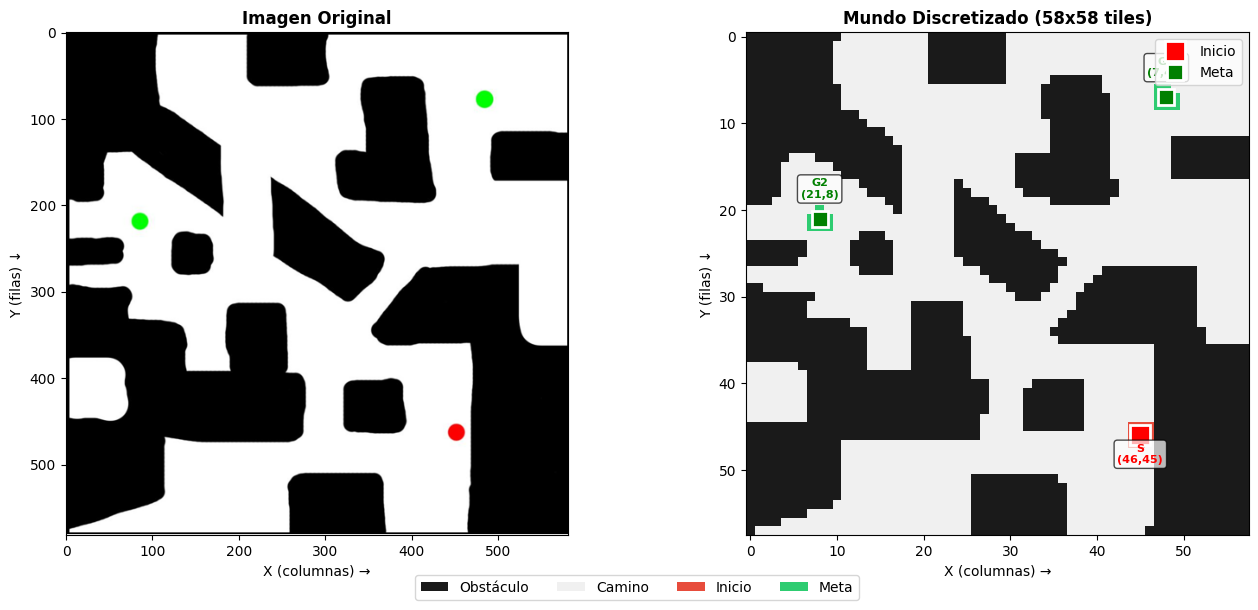


  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 1851
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]


In [88]:
IMAGE_FILE = "img/Test.bmp"  # Cambiar según la imagen deseada
TILE_SIZE = 10               # Ajustar según la resolución de la imagen

# Procesar y visualizar
world = process_maze_image(IMAGE_FILE, tile_size=TILE_SIZE)

**Representación ASCII**

In [ ]:
# Útil para grids pequeños
if world.grid_width <= 40 and world.grid_height <= 30:
    world.print_grid()
else:
    print(f"Grid demasiado grande para ASCII ({world.grid_width}x{world.grid_height})")
    print("Se omite la representación ASCII.")

Grid demasiado grande para ASCII (58x58)
Se omite la representación ASCII.


**Datos discretizados**

In [105]:
# Así se ven los datos discretizados para usar en algoritmos de búsqueda
print("Datos disponibles para algoritmos de búsqueda:")
print(f"  • Matriz del mundo (grid): {type(world.grid)} de forma {world.grid.shape}")
print(f"  • Posición inicial: {world.get_start()}")
print(f"  • Posiciones meta: {world.get_goals()}")
print("\nEjemplo de valores del grid (esquina superior izquierda 5x5):")
print(world.grid[:5, :5])

Datos disponibles para algoritmos de búsqueda:
  • Matriz del mundo (grid): <class 'numpy.ndarray'> de forma (58, 58)
  • Posición inicial: (46, 45)
  • Posiciones meta: [(7, 48), (21, 8)]

Ejemplo de valores del grid (esquina superior izquierda 5x5):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


**Resto de Imágenes**


  Procesando: Test2.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test2.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=42, col=42)
  [INFO] Se encontraron 2 grupos de GOAL:
    Grupo 1: 14 tiles → centroide en (7, 22)
    Grupo 2: 14 tiles → centroide en (36, 2)
  [OK] 2 meta(s) encontrada(s):
      Meta 1: (row=7, col=22)
      Meta 2: (row=36, col=2)

  Distribución de terrenos:
    OBSTACLE (Negro): 1687 (50.1%)
    PATH (Blanco): 1638 (48.7%)
    START (Rojo): 11 (0.3%)
    GOAL (Verde): 28 (0.8%)


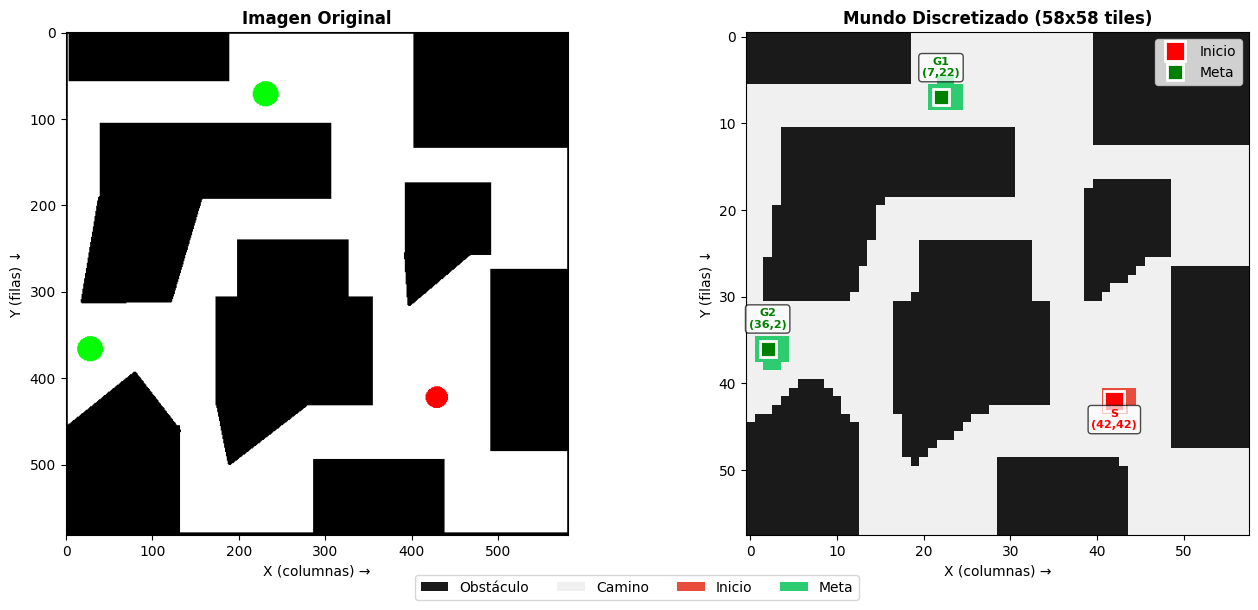


  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 1677
  • Inicio: (42, 42)
  • Metas: [(7, 22), (36, 2)]

  Procesando: Prueba Lab1.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Prueba Lab1.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=51, col=49)
  [OK] 1 meta(s) encontrada(s):
      Meta 1: (row=6, col=5)

  Distribución de terrenos:
    OBSTACLE (Negro): 641 (19.1%)
    PATH (Blanco): 2687 (79.9%)
    START (Rojo): 15 (0.4%)
    GOAL (Verde): 21 (0.6%)


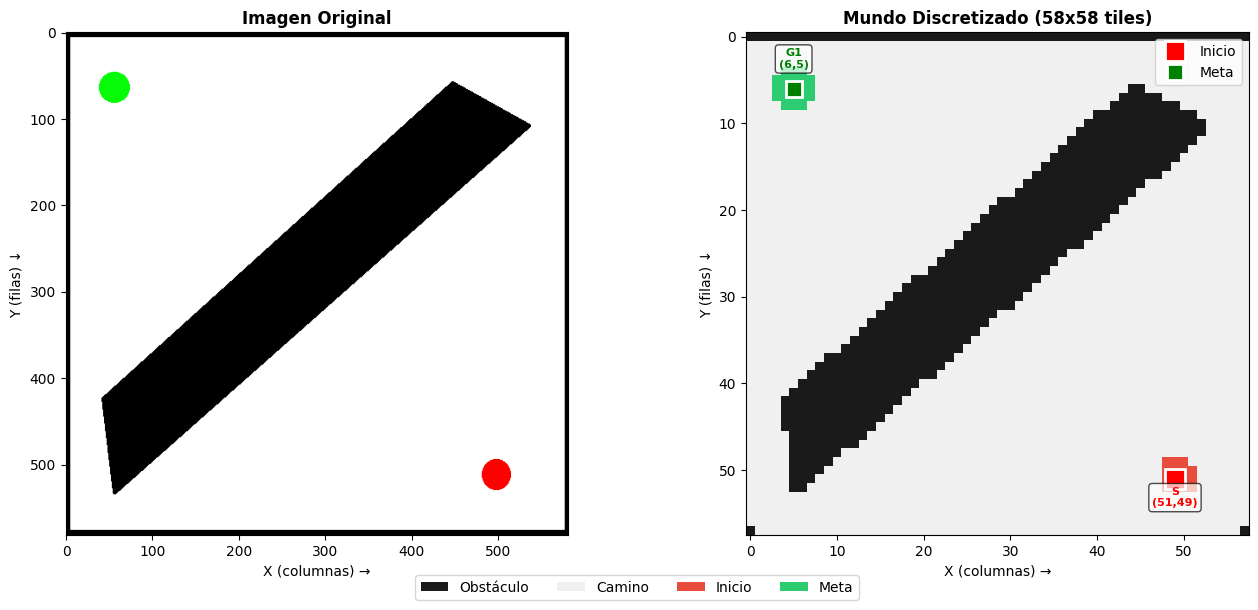


  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 2723
  • Inicio: (51, 49)
  • Metas: [(6, 5)]

  Procesando: turing.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/turing.bmp
  Dimensiones: 640 x 640 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 5x5 píxeles
  Dimensiones del grid: 128x128 tiles
  [OK] Inicio encontrado en: (row=87, col=28)
  [INFO] Se encontraron 4 grupos de GOAL:
    Grupo 1: 16 tiles → centroide en (50, 123)
    Grupo 2: 10 tiles → centroide en (74, 34)
    Grupo 3: 11 tiles → centroide en (106, 25)
    Grupo 4: 13 tiles → centroide en (110, 52)
  [OK] 4 meta(s) encontrada(s):
      Meta 1: (row=50, col=123)
      Meta 2: (row=74, col=34)
      Meta 3: (row=106, col=25)
      Meta 4: (row=110, col=52)

  Distribución de terrenos:
    OBSTACLE (Negro): 7164 (43.7%)
    PATH (Blanco): 9159 (55.9%)
    START (Rojo): 11 (0.1%)
    GOAL (Verde): 50 (0.3%)


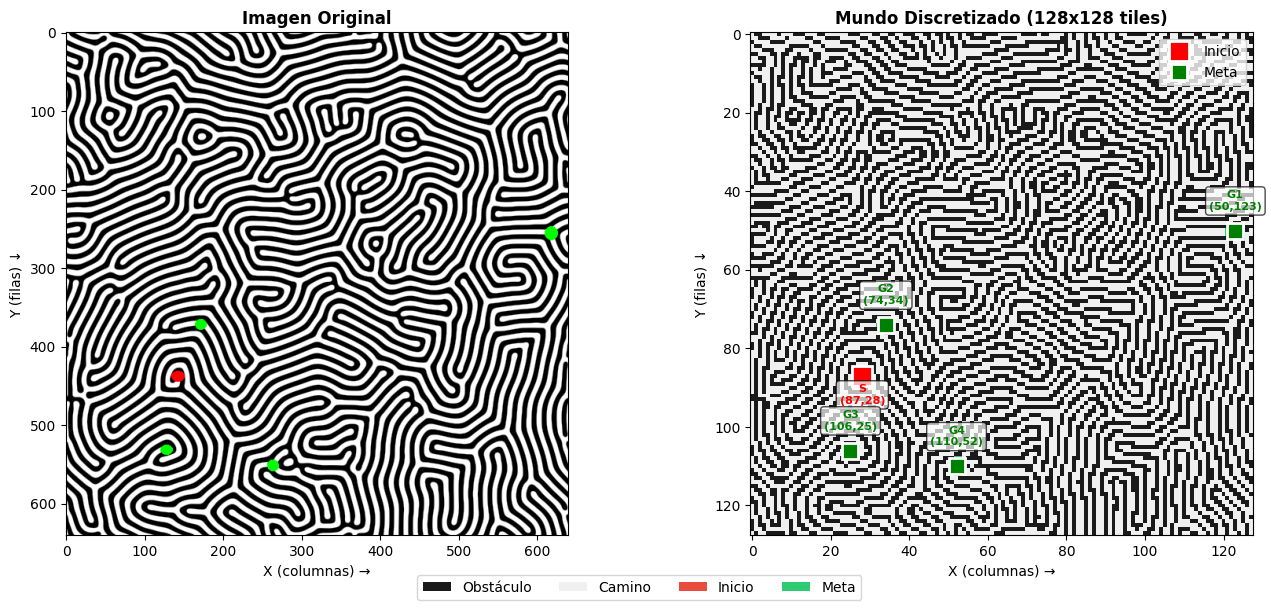


  RESUMEN
  • Grid size: 128 x 128
  • Total nodos: 16384
  • Nodos transitables: 9220
  • Inicio: (87, 28)
  • Metas: [(50, 123), (74, 34), (106, 25), (110, 52)]

  Procesando: Test.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=46, col=45)
  [INFO] Se encontraron 2 grupos de GOAL:
    Grupo 1: 8 tiles → centroide en (7, 48)
    Grupo 2: 7 tiles → centroide en (21, 8)
  [OK] 2 meta(s) encontrada(s):
      Meta 1: (row=7, col=48)
      Meta 2: (row=21, col=8)

  Distribución de terrenos:
    OBSTACLE (Negro): 1513 (45.0%)
    PATH (Blanco): 1828 (54.3%)
    START (Rojo): 8 (0.2%)
    GOAL (Verde): 15 (0.4%)


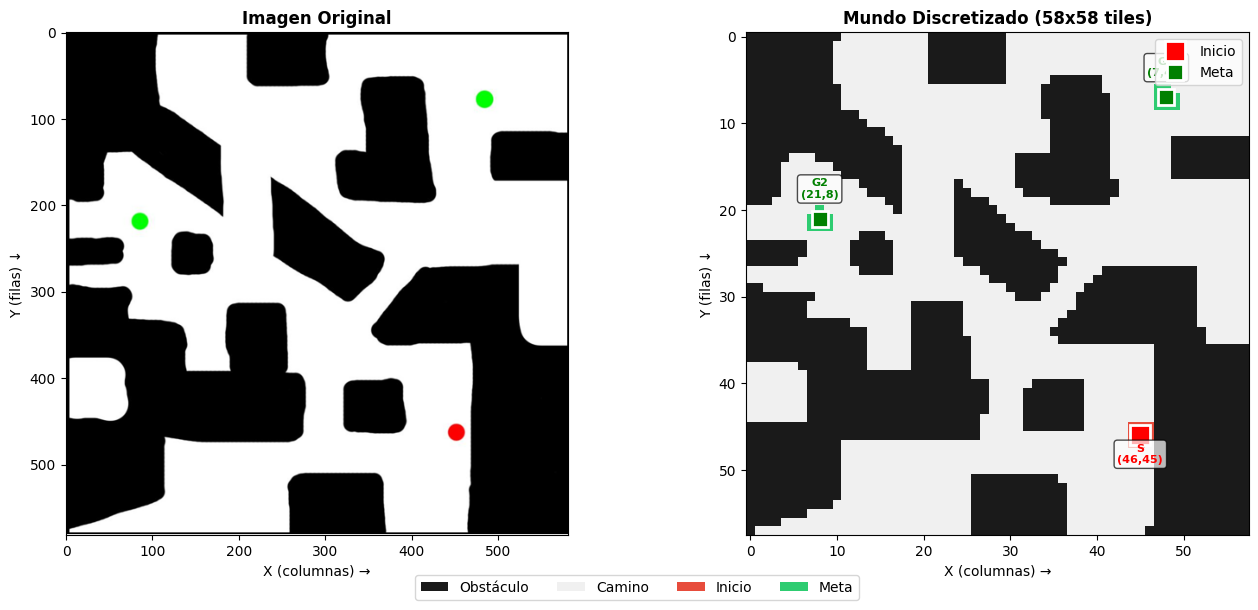


  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 1851
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]


In [106]:
# Probar con todas las imágenes disponibles
img_folder = "img"

if os.path.exists(img_folder):
    for img_name in os.listdir(img_folder):
        if img_name.endswith(('.png', '.bmp')):
            print(f"\n{'='*60}")
            print(f"  Procesando: {img_name}")
            print(f"{'='*60}")
            
            img_path = os.path.join(img_folder, img_name)
            
            # Determinar tile_size apropiado basado en el tamaño y tipo de imagen
            with Image.open(img_path) as im:
                max_dim = max(im.size)
                # turing.bmp tiene patrones orgánicos que requieren tiles más pequeños
                if 'turing' in img_name.lower():
                    tile_size = 5
                elif max_dim > 1000:
                    tile_size = 20
                elif max_dim > 500:
                    tile_size = 10
                else:
                    tile_size = 5
            
            try:
                discretizer = process_maze_image(img_path, tile_size=tile_size)
            except Exception as e:
                print(f"Error procesando {img_name}: {e}")

---

## Task 1.2 – Búsqueda

En esta sección implementamos el **framework genérico de búsqueda** siguiendo los conceptos de Programación Orientada a Objetos (POO).

### Componentes:
1. **SearchProblem (Clase Abstracta)**: Define la interfaz formal del problema
2. **MazeProblem**: Implementación específica para nuestro laberinto
3. **GraphSearch**: Algoritmo genérico de búsqueda en grafos
4. **BFS**: Búsqueda en anchura (menor cantidad de pasos)
5. **DFS**: Búsqueda en profundidad (exploración rápida)

### 1.2.1 Clase Abstracta SearchProblem

Se define la interfaz genérica que todo problema de búsqueda debe implementar.

In [70]:
class SearchProblem(ABC):
    """
    Clase abstracta que define la interfaz formal para un problema de búsqueda.
    
    Esta interfaz sigue el framework estándar de problemas de búsqueda:
    - initial_state(): Estado inicial
    - goal_test(state): Verifica si un estado es meta
    - actions(state): Acciones disponibles desde un estado
    - result(state, action): Estado resultante de aplicar una acción
    - step_cost(state, action, next_state): Costo de una transición
    """
    
    @abstractmethod
    def initial_state(self):
        """
        Retorna el estado inicial del problema.
        
        Returns:
            Estado inicial (formato depende de la implementación)
        """
        pass
    
    @abstractmethod
    def goal_test(self, state):
        """
        Verifica si un estado es un estado meta.
        
        Args:
            state: Estado a verificar
            
        Returns:
            bool: True si es estado meta, False en caso contrario
        """
        pass
    
    @abstractmethod
    def actions(self, state):
        """
        Retorna las acciones disponibles desde un estado.
        
        Args:
            state: Estado actual
            
        Returns:
            list: Lista de acciones posibles
        """
        pass
    
    @abstractmethod
    def result(self, state, action):
        """
        Retorna el estado resultante de aplicar una acción.
        
        Args:
            state: Estado actual
            action: Acción a aplicar
            
        Returns:
            Nuevo estado resultante
        """
        pass
    
    @abstractmethod
    def step_cost(self, state, action, next_state):
        """
        Retorna el costo de una transición de estado.
        
        Args:
            state: Estado actual
            action: Acción aplicada
            next_state: Estado resultante
            
        Returns:
            float: Costo de la transición
        """
        pass


class Node:
    """
    Nodo del árbol de búsqueda.
    
    Encapsula un estado junto con información del camino:
    - Estado actual
    - Nodo padre
    - Acción que llevó a este nodo
    - Costo acumulado del camino
    - Profundidad en el árbol
    """
    
    def __init__(self, state, parent=None, action=None, path_cost=0):
        """
        Inicializa un nodo del árbol de búsqueda.
        
        Args:
            state: Estado que representa este nodo
            parent (Node): Nodo padre en el árbol
            action: Acción que generó este nodo
            path_cost (float): Costo acumulado desde el inicio
        """
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0 if parent is None else parent.depth + 1
    
    def __repr__(self):
        return f"Node({self.state}, depth={self.depth}, cost={self.path_cost})"
    
    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state
    
    def __hash__(self):
        return hash(self.state)
    
    def expand(self, problem):
        """
        Expande el nodo generando todos sus sucesores.
        
        Args:
            problem (SearchProblem): Problema de búsqueda
            
        Yields:
            Node: Nodos hijos generados
        """
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            cost = self.path_cost + problem.step_cost(self.state, action, next_state)
            yield Node(next_state, self, action, cost)
    
    def path(self):
        """
        Reconstruye el camino desde el inicio hasta este nodo.
        
        Returns:
            list: Lista de estados desde el inicio hasta este nodo
        """
        node, path_back = self, []
        while node:
            path_back.append(node.state)
            node = node.parent
        return list(reversed(path_back))
    
    def solution(self):
        """
        Reconstruye la secuencia de acciones para llegar a este nodo.
        
        Returns:
            list: Lista de acciones desde el inicio
        """
        node, actions = self, []
        while node.parent:
            actions.append(node.action)
            node = node.parent
        return list(reversed(actions))

print("[OK] Clase abstracta SearchProblem y Node definidas")

[OK] Clase abstracta SearchProblem y Node definidas


### 1.2.2 Implementación MazeProblem

Implementación concreta del problema de búsqueda para nuestro laberinto discretizado.

In [71]:
class MazeProblem(SearchProblem):
    """
    Implementación del problema de búsqueda para un laberinto discretizado.
    
    El estado es una tupla (row, col) representando la posición en la grilla.
    Las acciones son movimientos en 4 direcciones: UP, DOWN, LEFT, RIGHT.
    
    Attributes:
        grid (np.ndarray): Matriz discretizada del mundo
        start (tuple): Posición inicial (row, col)
        goals (list): Lista de posiciones meta
        height (int): Altura de la grilla
        width (int): Anchura de la grilla
    """
    
    # Definición de acciones como movimientos (delta_row, delta_col)
    ACTIONS = {
        'UP': (-1, 0),
        'DOWN': (1, 0),
        'LEFT': (0, -1),
        'RIGHT': (0, 1)
    }
    
    def __init__(self, discretizer):
        """
        Inicializa el problema a partir de un WorldDiscretizer.
        
        Args:
            discretizer (WorldDiscretizer): Mundo discretizado con grid, inicio y metas
        """
        self.grid = discretizer.get_grid()
        self.start = discretizer.get_start()
        self.goals = discretizer.get_goals()
        self.height, self.width = self.grid.shape
        self.discretizer = discretizer  # Guardamos referencia para visualización
        
        # Validación
        if self.start is None:
            raise ValueError("No se encontró punto de inicio en el laberinto")
        if not self.goals:
            raise ValueError("No se encontraron metas en el laberinto")
        
        print("[OK] MazeProblem inicializado")
        print(f"  • Grid: {self.width}x{self.height}")
        print(f"  • Inicio: {self.start}")
        print(f"  • Metas: {self.goals}")
    
    def initial_state(self):
        """Retorna la posición inicial."""
        return self.start
    
    def goal_test(self, state):
        """Verifica si la posición es una meta."""
        return state in self.goals
    
    def actions(self, state):
        """
        Retorna las acciones válidas desde una posición.
        
        Una acción es válida si:
        1. La posición resultante está dentro de los límites
        2. La posición resultante no es un obstáculo
        
        Args:
            state (tuple): Posición actual (row, col)
            
        Returns:
            list: Lista de nombres de acciones válidas
        """
        row, col = state
        valid_actions = []
        
        for action_name, (dr, dc) in self.ACTIONS.items():
            new_row, new_col = row + dr, col + dc
            
            # Verificar límites
            if 0 <= new_row < self.height and 0 <= new_col < self.width:
                # Verificar que no sea obstáculo
                if self.grid[new_row, new_col] != TerrainType.OBSTACLE:
                    valid_actions.append(action_name)
        
        return valid_actions
    
    def result(self, state, action):
        """
        Calcula el estado resultante de aplicar una acción.
        
        Args:
            state (tuple): Posición actual (row, col)
            action (str): Nombre de la acción
            
        Returns:
            tuple: Nueva posición (row, col)
        """
        row, col = state
        dr, dc = self.ACTIONS[action]
        return (row + dr, col + dc)
    
    def step_cost(self, state, action, next_state):
        """
        Retorna el costo de moverse de una celda a otra.
        
        Para Task 1.2, el costo es uniforme (1) para todo movimiento válido.
        Esto se modificará en Task 2 para considerar tipos de terreno.
        
        Args:
            state (tuple): Posición actual
            action (str): Acción aplicada
            next_state (tuple): Posición resultante
            
        Returns:
            float: Costo de la transición (1 por defecto)
        """
        return 1
    
    def heuristic(self, state):
        """
        Calcula la heurística (distancia Manhattan) al goal más cercano.
        
        Esta función se usará en A* (Task 1.3).
        
        Args:
            state (tuple): Posición actual (row, col)
            
        Returns:
            float: Distancia Manhattan mínima a cualquier meta
        """
        row, col = state
        min_distance = float('inf')
        
        for goal_row, goal_col in self.goals:
            distance = abs(row - goal_row) + abs(col - goal_col)
            min_distance = min(min_distance, distance)
        
        return min_distance

print("[OK] Clase MazeProblem definida")

[OK] Clase MazeProblem definida


### 1.2.3 Algoritmo Genérico GraphSearch

Implementación del algoritmo genérico de búsqueda en grafos.

In [72]:
class GraphSearch:
    """
    Algoritmo genérico de búsqueda en grafos.
    
    Esta clase implementa el patrón de búsqueda en grafos donde la estructura
    de datos de la frontera (frontier) determina el comportamiento:
    - Cola (FIFO) → BFS
    - Pila (LIFO) → DFS
    
    Attributes:
        problem (SearchProblem): Problema a resolver
        frontier_type (str): Tipo de frontera ('queue' para BFS, 'stack' para DFS)
    """
    
    def __init__(self, problem, frontier_type='queue'):
        """
        Inicializa el algoritmo de búsqueda.
        
        Args:
            problem (SearchProblem): Problema de búsqueda
            frontier_type (str): 'queue' para BFS, 'stack' para DFS
        """
        self.problem = problem
        self.frontier_type = frontier_type
        self.nodes_expanded = 0
        self.nodes_generated = 0
        self.solution_node = None
    
    def search(self, verbose=False):
        """
        Ejecuta la búsqueda en el grafo.
        
        Args:
            verbose (bool): Si True, imprime información durante la búsqueda
            
        Returns:
            Node: Nodo solución si se encuentra, None si no hay solución
        """
        # Inicializar con el nodo inicial
        initial_node = Node(self.problem.initial_state())
        
        # Verificar si el estado inicial es meta
        if self.problem.goal_test(initial_node.state):
            self.solution_node = initial_node
            return initial_node
        
        # Inicializar frontera según el tipo
        if self.frontier_type == 'queue':
            frontier = deque([initial_node])  # Cola para BFS
        else:
            frontier = [initial_node]  # Lista como pila para DFS
        
        # Conjunto de estados alcanzados (explorados + en frontera)
        # Esto previene agregar duplicados a la frontera
        reached = {initial_node.state}
        
        self.nodes_generated = 1
        self.nodes_expanded = 0
        
        while frontier:
            # Extraer nodo según tipo de frontera
            if self.frontier_type == 'queue':
                node = frontier.popleft()  # FIFO para BFS
            else:
                node = frontier.pop()  # LIFO para DFS
            
            self.nodes_expanded += 1
            
            if verbose and self.nodes_expanded % 100 == 0:
                print(f"  Nodos expandidos: {self.nodes_expanded}, Frontera: {len(frontier)}")
            
            # Expandir el nodo
            for child in node.expand(self.problem):
                self.nodes_generated += 1
                
                # Verificar si el estado ya fue alcanzado (explorado o en frontera)
                if child.state not in reached:
                    # Verificar si es meta
                    if self.problem.goal_test(child.state):
                        self.solution_node = child
                        if verbose:
                            print(f"  ¡Meta encontrada! Nodos expandidos: {self.nodes_expanded}")
                        return child
                    
                    # Marcar como alcanzado y agregar a la frontera
                    reached.add(child.state)
                    frontier.append(child)
        
        # No se encontró solución
        if verbose:
            print("  No se encontró solución")
        return None
    
    def get_statistics(self):
        """
        Retorna estadísticas de la búsqueda.
        
        Returns:
            dict: Diccionario con estadísticas
        """
        return {
            'nodes_expanded': self.nodes_expanded,
            'nodes_generated': self.nodes_generated,
            'solution_found': self.solution_node is not None,
            'path_length': len(self.solution_node.path()) if self.solution_node else 0,
            'path_cost': self.solution_node.path_cost if self.solution_node else 0
        }


def bfs(problem, verbose=False):
    """
    Búsqueda en Anchura (Breadth-First Search).
    
    Encuentra el camino con la menor cantidad de pasos.
    
    Args:
        problem (SearchProblem): Problema a resolver
        verbose (bool): Si mostrar progreso
        
    Returns:
        tuple: (path, stats) - Camino encontrado y estadísticas
    """
    print("="*60)
    print("  BFS - Búsqueda en Anchura")
    print("="*60)
    
    searcher = GraphSearch(problem, frontier_type='queue')
    solution = searcher.search(verbose)
    stats = searcher.get_statistics()
    
    if solution:
        path = solution.path()
        print("  [OK] Solución encontrada")
        print(f"    • Longitud del camino: {len(path)} pasos")
        print(f"    • Nodos expandidos: {stats['nodes_expanded']}")
        print(f"    • Nodos generados: {stats['nodes_generated']}")
        return path, stats
    else:
        print("  [X] No se encontró solución")
        return None, stats


def dfs(problem, verbose=False):
    """
    Búsqueda en Profundidad (Depth-First Search).
    
    Explora caminos rápidamente, pero no garantiza el camino más corto.
    
    Args:
        problem (SearchProblem): Problema a resolver
        verbose (bool): Si mostrar progreso
        
    Returns:
        tuple: (path, stats) - Camino encontrado y estadísticas
    """
    print("="*60)
    print("  DFS - Búsqueda en Profundidad")
    print("="*60)
    
    searcher = GraphSearch(problem, frontier_type='stack')
    solution = searcher.search(verbose)
    stats = searcher.get_statistics()
    
    if solution:
        path = solution.path()
        print("  [OK] Solución encontrada")
        print(f"    • Longitud del camino: {len(path)} pasos")
        print(f"    • Nodos expandidos: {stats['nodes_expanded']}")
        print(f"    • Nodos generados: {stats['nodes_generated']}")
        return path, stats
    else:
        print("  [X] No se encontró solución")
        return None, stats

print("[OK] GraphSearch, BFS y DFS definidos")

[OK] GraphSearch, BFS y DFS definidos


### 1.2.4 Visualización de Rutas

Funciones para dibujar la ruta encontrada sobre la imagen original y la representación discretizada.

In [73]:
def visualize_path(discretizer, path, title="Ruta Encontrada", figsize=(14, 6)):
    """
    Visualiza la ruta encontrada sobre la imagen original y el grid discretizado.
    
    Args:
        discretizer (WorldDiscretizer): Mundo discretizado con la imagen original
        path (list): Lista de estados (row, col) que forman la ruta
        title (str): Título para la figura
        figsize (tuple): Tamaño de la figura
    """
    if path is None:
        print("No hay ruta para visualizar")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # === Panel izquierdo: Imagen original con ruta ===
    axes[0].imshow(discretizer.original_image)
    
    # Convertir coordenadas del grid a coordenadas de píxeles
    tile_size = discretizer.tile_size
    path_x = [(col * tile_size) + tile_size // 2 for row, col in path]
    path_y = [(row * tile_size) + tile_size // 2 for row, col in path]
    
    # Dibujar la ruta como línea
    axes[0].plot(path_x, path_y, 'b-', linewidth=2, alpha=0.8, label='Ruta')
    axes[0].plot(path_x, path_y, 'bo', markersize=3, alpha=0.6)
    
    # Marcar inicio y fin
    axes[0].plot(path_x[0], path_y[0], 'rs', markersize=20, 
                markeredgecolor='white', markeredgewidth=1, label='Inicio')
    axes[0].plot(path_x[-1], path_y[-1], 'gs', markersize=15, 
                markeredgecolor='white', markeredgewidth=1, label='Meta')
    
    axes[0].set_title(f'{title} - Imagen Original', fontsize=12, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].axis('off')
    
    # === Panel derecho: Grid discretizado con ruta ===
    colors = ['#1a1a1a', '#f0f0f0', '#e74c3c', '#2ecc71']
    cmap = ListedColormap(colors)
    
    axes[1].imshow(discretizer.grid, cmap=cmap, vmin=0, vmax=3)
    
    # Dibujar la ruta en coordenadas del grid
    path_cols = [col for row, col in path]
    path_rows = [row for row, col in path]
    
    axes[1].plot(path_cols, path_rows, 'b-', linewidth=2.5, alpha=0.8, label='Ruta')
    axes[1].plot(path_cols, path_rows, 'bo', markersize=4, alpha=0.6)
    
    # Marcar inicio y fin
    axes[1].plot(path_cols[0], path_rows[0], 'rs', markersize=20, 
                markeredgecolor='white', markeredgewidth=1, label='Inicio')
    axes[1].plot(path_cols[-1], path_rows[-1], 'gs', markersize=15, 
                markeredgecolor='white', markeredgewidth=1, label='Meta')
    
    axes[1].set_title(f'{title} - Grid Discretizado ({len(path)} pasos)', 
                    fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right')
    
    # Grid visual si es suficientemente pequeño
    if discretizer.grid_width <= 50:
        axes[1].set_xticks(np.arange(-0.5, discretizer.grid_width, 1), minor=True)
        axes[1].set_yticks(np.arange(-0.5, discretizer.grid_height, 1), minor=True)
        axes[1].grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.5)
    
    plt.tight_layout()
    plt.show()


def compare_algorithms(discretizer, figsize=(16, 10)):
    """
    Compara los algoritmos BFS y DFS en el mismo laberinto.
    
    Args:
        discretizer (WorldDiscretizer): Mundo discretizado
        figsize (tuple): Tamaño de la figura
    """
    # Crear problema
    problem = MazeProblem(discretizer)
    
    # Ejecutar BFS
    print("\n" + "="*60)
    bfs_path, bfs_stats = bfs(problem)
    
    # Ejecutar DFS
    print("\n" + "="*60)
    dfs_path, dfs_stats = dfs(problem)
    
    # Visualización comparativa
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    colors = ['#1a1a1a', '#f0f0f0', '#e74c3c', '#2ecc71']
    cmap = ListedColormap(colors)
    
    # === Fila 1: BFS ===
    # Imagen original
    axes[0, 0].imshow(discretizer.original_image)
    if bfs_path:
        tile_size = discretizer.tile_size
        path_x = [(col * tile_size) + tile_size // 2 for row, col in bfs_path]
        path_y = [(row * tile_size) + tile_size // 2 for row, col in bfs_path]
        axes[0, 0].plot(path_x, path_y, 'b-', linewidth=2, alpha=0.8)
        axes[0, 0].plot(path_x[0], path_y[0], 'rs', markersize=15)
        axes[0, 0].plot(path_x[-1], path_y[-1], 'gs', markersize=12)
    axes[0, 0].set_title(f'BFS - Imagen Original ({len(bfs_path) if bfs_path else 0} pasos)', 
                        fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Grid
    axes[0, 1].imshow(discretizer.grid, cmap=cmap, vmin=0, vmax=3)
    if bfs_path:
        path_cols = [col for row, col in bfs_path]
        path_rows = [row for row, col in bfs_path]
        axes[0, 1].plot(path_cols, path_rows, 'b-', linewidth=2.5, alpha=0.8)
        axes[0, 1].plot(path_cols[0], path_rows[0], 'rs', markersize=15)
        axes[0, 1].plot(path_cols[-1], path_rows[-1], 'gs', markersize=12)
    axes[0, 1].set_title(f'BFS - Grid (Expandidos: {bfs_stats["nodes_expanded"]})', 
                        fontsize=11, fontweight='bold')
    
    # === Fila 2: DFS ===
    # Imagen original
    axes[1, 0].imshow(discretizer.original_image)
    if dfs_path:
        tile_size = discretizer.tile_size
        path_x = [(col * tile_size) + tile_size // 2 for row, col in dfs_path]
        path_y = [(row * tile_size) + tile_size // 2 for row, col in dfs_path]
        axes[1, 0].plot(path_x, path_y, 'orange', linewidth=2, alpha=0.8)
        axes[1, 0].plot(path_x[0], path_y[0], 'rs', markersize=15)
        axes[1, 0].plot(path_x[-1], path_y[-1], 'gs', markersize=12)
    axes[1, 0].set_title(f'DFS - Imagen Original ({len(dfs_path) if dfs_path else 0} pasos)', 
                        fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Grid
    axes[1, 1].imshow(discretizer.grid, cmap=cmap, vmin=0, vmax=3)
    if dfs_path:
        path_cols = [col for row, col in dfs_path]
        path_rows = [row for row, col in dfs_path]
        axes[1, 1].plot(path_cols, path_rows, 'orange', linewidth=2.5, alpha=0.8)
        axes[1, 1].plot(path_cols[0], path_rows[0], 'rs', markersize=15)
        axes[1, 1].plot(path_cols[-1], path_rows[-1], 'gs', markersize=12)
    axes[1, 1].set_title(f'DFS - Grid (Expandidos: {dfs_stats["nodes_expanded"]})', 
                        fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla comparativa
    print("\n" + "="*60)
    print("  COMPARACIÓN DE ALGORITMOS")
    print("="*60)
    print(f"  {'Métrica':<25} {'BFS':<15} {'DFS':<15}")
    print("  " + "-"*55)
    print(f"  {'Longitud del camino':<25} {len(bfs_path) if bfs_path else 'N/A':<15} {len(dfs_path) if dfs_path else 'N/A':<15}")
    print(f"  {'Nodos expandidos':<25} {bfs_stats['nodes_expanded']:<15} {dfs_stats['nodes_expanded']:<15}")
    print(f"  {'Nodos generados':<25} {bfs_stats['nodes_generated']:<15} {dfs_stats['nodes_generated']:<15}")
    print(f"  {'Camino óptimo':<25} {'Sí':<15} {'No garantizado':<15}")
    
    return bfs_path, dfs_path, bfs_stats, dfs_stats

print("[OK] Funciones de visualización definidas")

[OK] Funciones de visualización definidas


### 1.2.5 Ejemplos

Ejecutamos BFS y DFS en el laberinto discretizado y visualizamos los resultados.

[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]
[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]

  BFS - Búsqueda en Anchura
  [OK] Solución encontrada
    • Longitud del camino: 63 pasos
    • Nodos expandidos: 1348
    • Nodos generados: 4967

  DFS - Búsqueda en Profundidad
  [OK] Solución encontrada
    • Longitud del camino: 221 pasos
    • Nodos expandidos: 568
    • Nodos generados: 2045


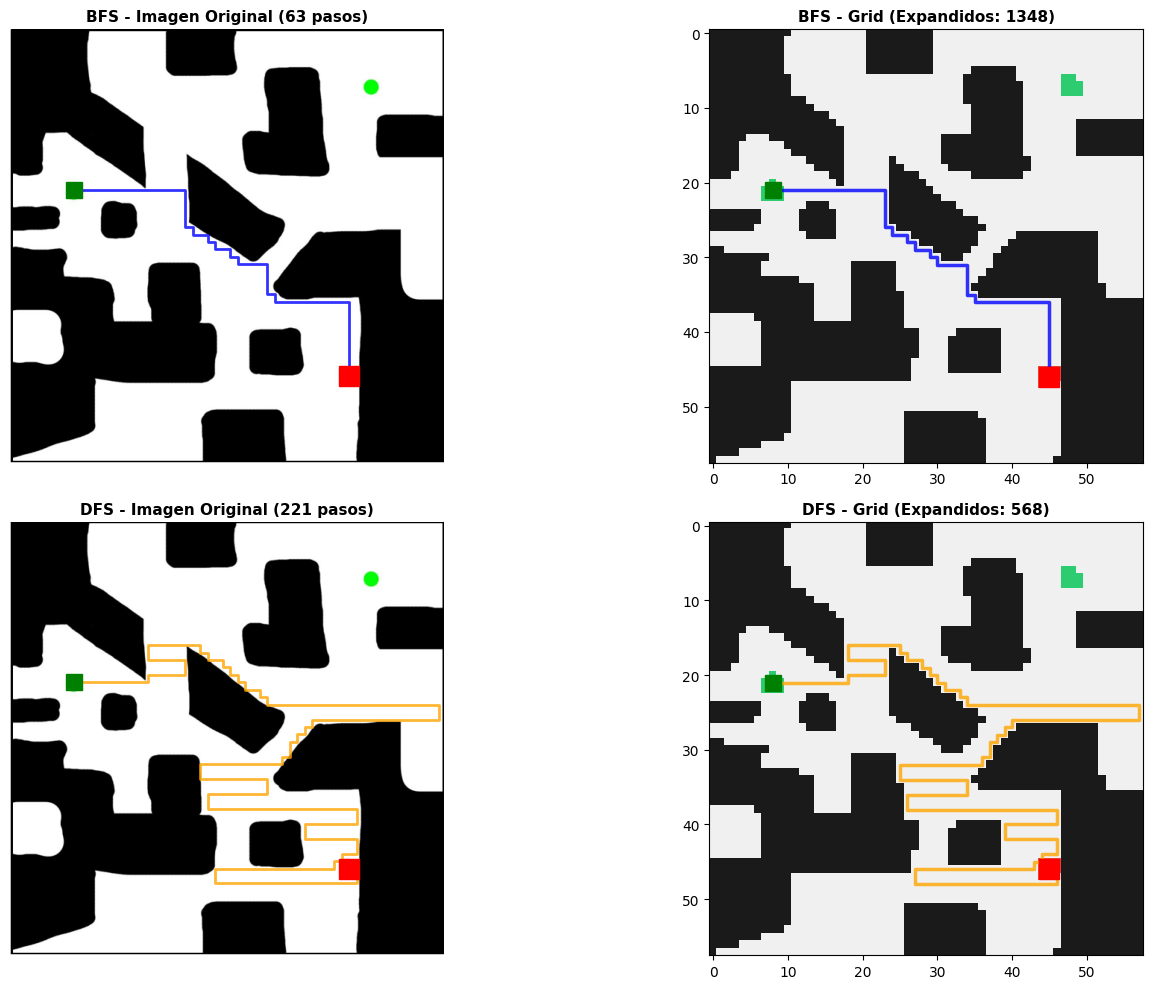


  COMPARACIÓN DE ALGORITMOS
  Métrica                   BFS             DFS            
  -------------------------------------------------------
  Longitud del camino       63              221            
  Nodos expandidos          1348            568            
  Nodos generados           4967            2045           
  Camino óptimo             Sí              No garantizado 


In [74]:
# Usar el mundo que ya discretizamos en Task 1.1
# Si no existe, cargarlo de nuevo
if 'world' not in dir() or world is None:
    IMAGE_FILE = "img/Test.bmp"
    TILE_SIZE = 10
    world = process_maze_image(IMAGE_FILE, tile_size=TILE_SIZE, visualize=False)

# Crear el problema de búsqueda
maze_problem = MazeProblem(world)

# Comparar BFS vs DFS
bfs_path, dfs_path, bfs_stats, dfs_stats = compare_algorithms(world)

**Visualizar solo BFS**

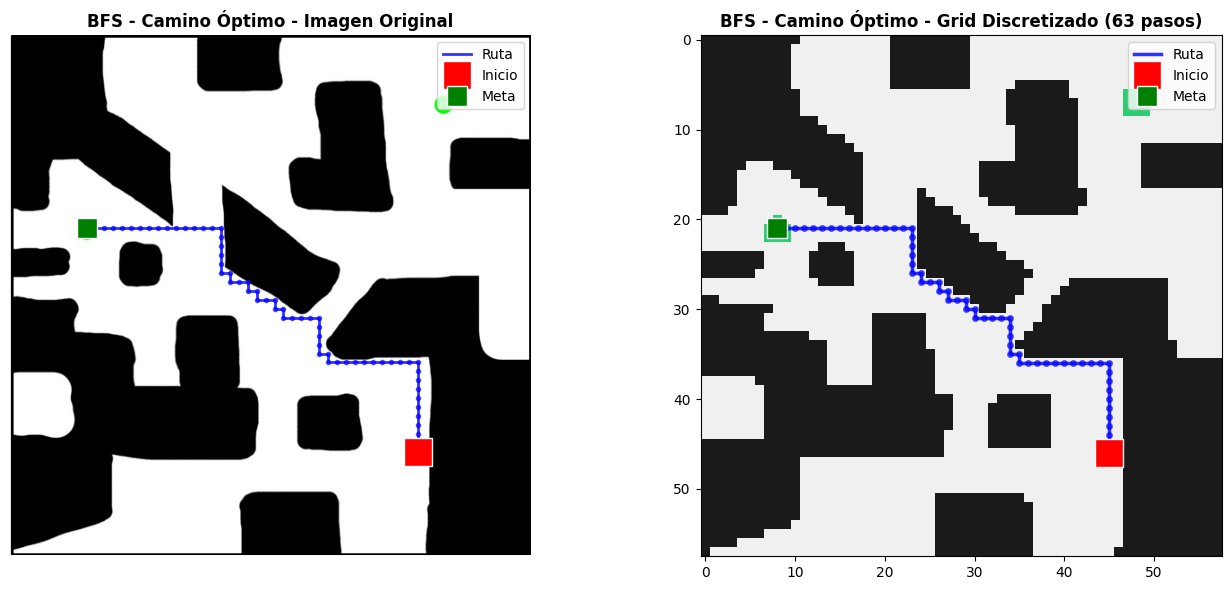

In [ ]:
visualize_path(world, bfs_path, title="BFS - Camino Óptimo")

**Visualizar solo DFS**

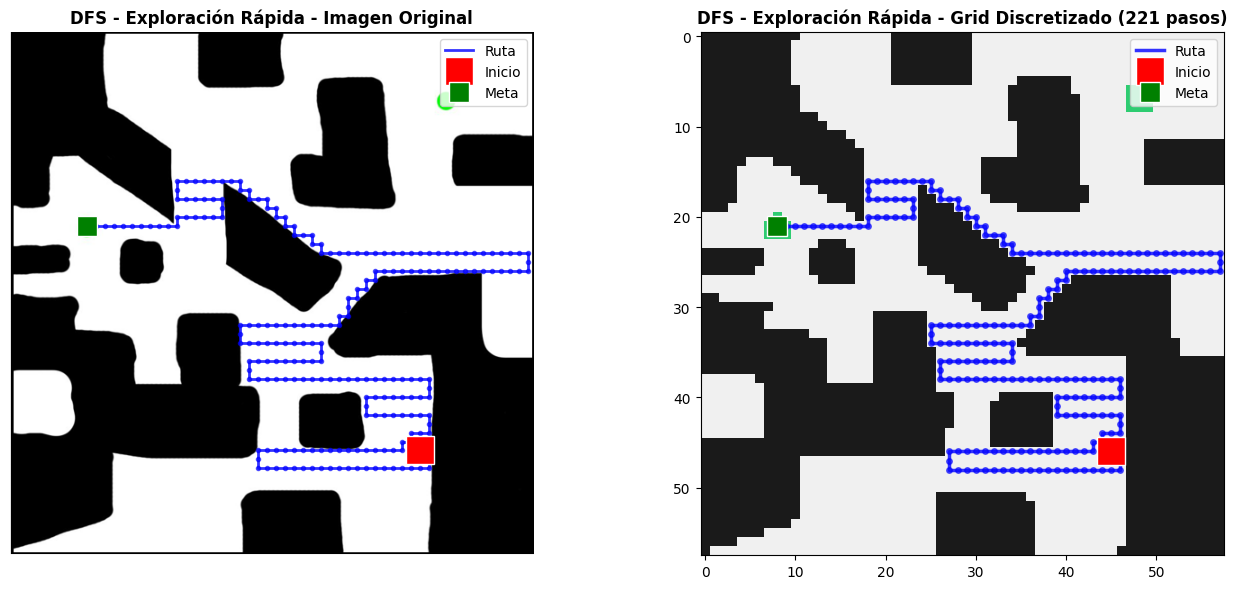

In [ ]:
visualize_path(world, dfs_path, title="DFS - Exploración Rápida")

**Prueba con otra imagen**

Procesando: img/Test2.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test2.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=42, col=42)
  [INFO] Se encontraron 2 grupos de GOAL:
    Grupo 1: 14 tiles → centroide en (7, 22)
    Grupo 2: 14 tiles → centroide en (36, 2)
  [OK] 2 meta(s) encontrada(s):
      Meta 1: (row=7, col=22)
      Meta 2: (row=36, col=2)

  Distribución de terrenos:
    OBSTACLE (Negro): 1687 (50.1%)
    PATH (Blanco): 1638 (48.7%)
    START (Rojo): 11 (0.3%)
    GOAL (Verde): 28 (0.8%)

  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 1677
  • Inicio: (42, 42)
  • Metas: [(7, 22), (36, 2)]
[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (42, 42)
  • Metas: [(7, 22), (36, 2)]

  BFS - Búsqueda en Anchura
  [OK] Solución encontrada
    • Longitud del camino: 56 pasos
    • Nodo

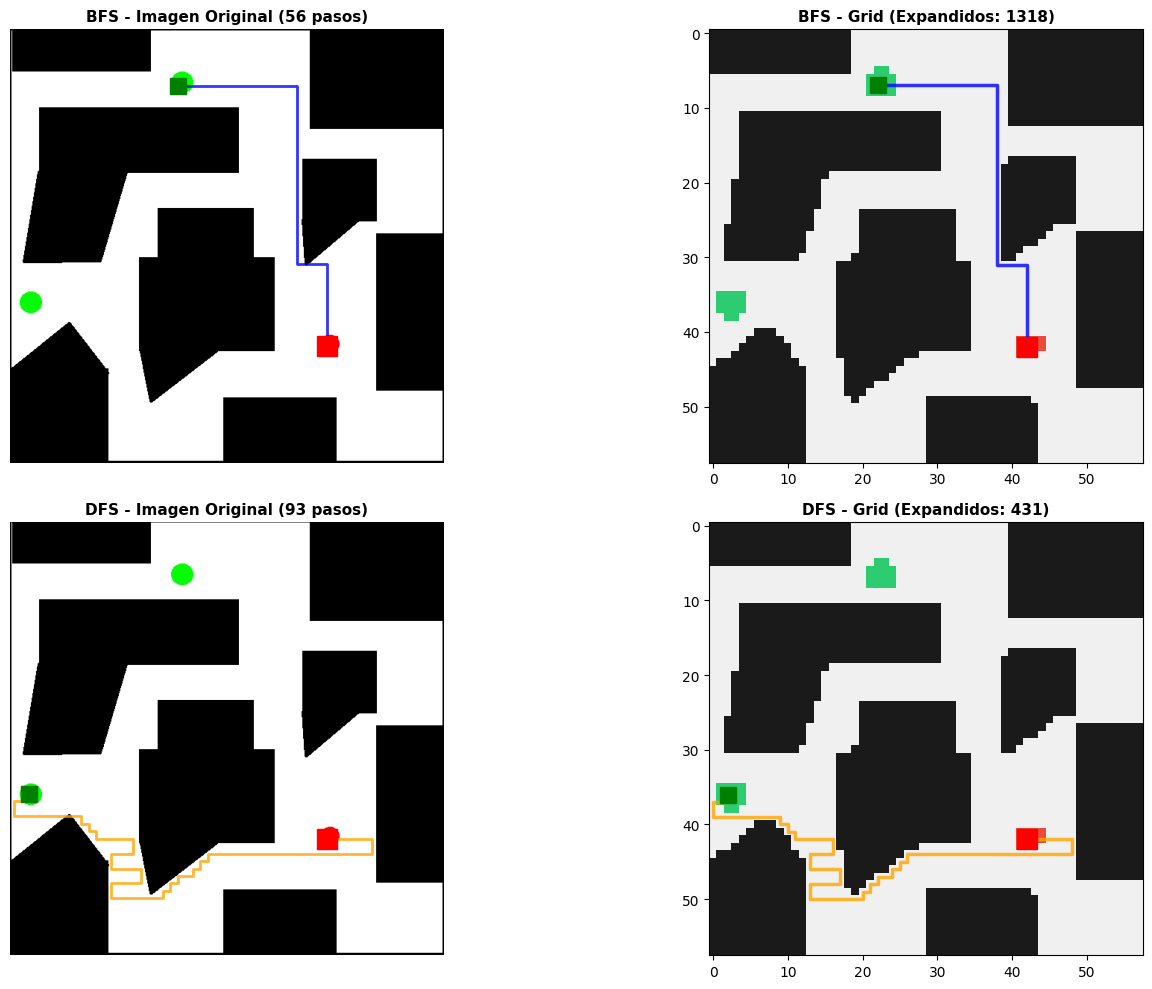


  COMPARACIÓN DE ALGORITMOS
  Métrica                   BFS             DFS            
  -------------------------------------------------------
  Longitud del camino       56              93             
  Nodos expandidos          1318            431            
  Nodos generados           4900            1574           
  Camino óptimo             Sí              No garantizado 


In [77]:
# Probar con otra imagen del laberinto
# Puedes cambiar el nombre del archivo según las imágenes disponibles

OTHER_IMAGE = "img/Test2.bmp"  # Cambiar según disponibilidad

if os.path.exists(OTHER_IMAGE):
    # Determinar tile_size apropiado basado en tipo de imagen
    with Image.open(OTHER_IMAGE) as im:
        max_dim = max(im.size)
        # turing.bmp tiene patrones orgánicos que requieren tiles más pequeños
        if 'turing' in OTHER_IMAGE.lower():
            tile_size = 5
        elif max_dim > 1000:
            tile_size = 20
        elif max_dim > 500:
            tile_size = 10
        else:
            tile_size = 5
    
    print(f"Procesando: {OTHER_IMAGE}")
    world2 = process_maze_image(OTHER_IMAGE, tile_size=tile_size, visualize=False)
    
    # Comparar algoritmos
    compare_algorithms(world2)
else:
    print(f"Imagen no encontrada: {OTHER_IMAGE}")

---

## Task 1.3 – Búsqueda A* (A-star)

En esta sección implementamos el algoritmo **A*** que combina:
- **g(n)**: Costo real desde el inicio hasta el nodo n
- **h(n)**: Heurística - estimación del costo desde n hasta la meta

Fórmula: $f(n) = g(n) + h(n)$

Heurística utilizada: **Distancia Manhattan**

$$h(n) = |x_n - x_{goal}| + |y_n - y_{goal}|$$

Esta heurística es **admisible** (nunca sobreestima) y **consistente**, lo que garantiza que A* encuentre el camino óptimo.

### 1.3.1 Implementación del Algoritmo A*

In [78]:
import heapq

class AStarSearch:
    """
    Implementación del algoritmo A* (A-star).
    
    A* combina el costo real del camino (g) con una heurística (h)
    para encontrar el camino óptimo de manera eficiente.
    
    f(n) = g(n) + h(n)
    
    Donde:
    - g(n): costo del camino desde el inicio hasta n
    - h(n): estimación heurística del costo desde n hasta la meta
    
    Attributes:
        problem (SearchProblem): Problema a resolver
    """
    
    def __init__(self, problem):
        """
        Inicializa A*.
        
        Args:
            problem (SearchProblem): Problema de búsqueda con método heuristic()
        """
        self.problem = problem
        self.nodes_expanded = 0
        self.nodes_generated = 0
        self.solution_node = None
    
    def search(self, verbose=False):
        """
        Ejecuta la búsqueda A*.
        
        Utiliza una cola de prioridad (min-heap) ordenada por f(n) = g(n) + h(n).
        
        Args:
            verbose (bool): Si True, imprime información durante la búsqueda
            
        Returns:
            Node: Nodo solución si se encuentra, None si no hay solución
        """
        # Nodo inicial
        initial_state = self.problem.initial_state()
        initial_node = Node(initial_state)
        
        # Verificar si el estado inicial es meta
        if self.problem.goal_test(initial_state):
            self.solution_node = initial_node
            return initial_node
        
        # Cola de prioridad: (f_score, contador, nodo)
        # El contador evita comparar nodos cuando f_scores son iguales
        counter = 0
        h_initial = self.problem.heuristic(initial_state)
        frontier = [(h_initial, counter, initial_node)]  # f = g + h = 0 + h
        heapq.heapify(frontier)
        
        # Diccionario de estados alcanzados con su mejor g_score
        # Esto permite re-explorar si encontramos un mejor camino
        reached = {initial_state: 0}
        
        self.nodes_generated = 1
        self.nodes_expanded = 0
        
        while frontier:
            # Extraer nodo con menor f_score
            f_score, _, node = heapq.heappop(frontier)
            
            # Verificar si es meta (verificación tardía)
            if self.problem.goal_test(node.state):
                self.solution_node = node
                if verbose:
                    print(f"  ¡Meta encontrada! Nodos expandidos: {self.nodes_expanded}")
                return node
            
            self.nodes_expanded += 1
            
            if verbose and self.nodes_expanded % 100 == 0:
                print(f"  Nodos expandidos: {self.nodes_expanded}, Frontera: {len(frontier)}")
            
            # Expandir el nodo
            for child in node.expand(self.problem):
                self.nodes_generated += 1
                g_score = child.path_cost
                
                # Solo procesar si es un nuevo estado o encontramos mejor camino
                if child.state not in reached or g_score < reached[child.state]:
                    reached[child.state] = g_score
                    h_score = self.problem.heuristic(child.state)
                    f_score = g_score + h_score
                    
                    counter += 1
                    heapq.heappush(frontier, (f_score, counter, child))
        
        # No se encontró solución
        if verbose:
            print("  No se encontró solución")
        return None
    
    def get_statistics(self):
        """
        Retorna estadísticas de la búsqueda.
        
        Returns:
            dict: Diccionario con estadísticas
        """
        return {
            'nodes_expanded': self.nodes_expanded,
            'nodes_generated': self.nodes_generated,
            'solution_found': self.solution_node is not None,
            'path_length': len(self.solution_node.path()) if self.solution_node else 0,
            'path_cost': self.solution_node.path_cost if self.solution_node else 0
        }


def astar(problem, verbose=False):
    """
    Búsqueda A* (A-star).
    
    Encuentra el camino óptimo usando heurística para guiar la búsqueda.
    
    Args:
        problem (SearchProblem): Problema a resolver (debe tener método heuristic)
        verbose (bool): Si mostrar progreso
        
    Returns:
        tuple: (path, stats) - Camino encontrado y estadísticas
    """
    print("="*60)
    print("  A* - Búsqueda A-Star")
    print("="*60)
    
    searcher = AStarSearch(problem)
    solution = searcher.search(verbose)
    stats = searcher.get_statistics()
    
    if solution:
        path = solution.path()
        print("  [OK] Solución encontrada")
        print(f"    • Longitud del camino: {len(path)} pasos")
        print(f"    • Costo total: {stats['path_cost']}")
        print(f"    • Nodos expandidos: {stats['nodes_expanded']}")
        print(f"    • Nodos generados: {stats['nodes_generated']}")
        return path, stats
    else:
        print("  [X] No se encontró solución")
        return None, stats

print("[OK] Algoritmo A* definido")

[OK] Algoritmo A* definido


### 1.3.2 Visualización en Matriz Discreta

Función para mostrar el camino encontrado sobre la representación discreta del laberinto.

In [79]:
def visualize_path_discrete(discretizer, path, title="Camino Encontrado", figsize=(10, 10)):
    """
    Visualiza la ruta encontrada SOLO sobre la matriz discreta.
    
    Args:
        discretizer (WorldDiscretizer): Mundo discretizado
        path (list): Lista de estados (row, col) que forman la ruta
        title (str): Título para la figura
        figsize (tuple): Tamaño de la figura
    """
    if path is None:
        print("No hay ruta para visualizar")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Colores: Negro=Obstáculo, Blanco=Camino, Rojo=Inicio, Verde=Meta
    colors = ['#1a1a1a', '#f0f0f0', '#e74c3c', '#2ecc71']
    cmap = ListedColormap(colors)
    
    # Mostrar el grid discretizado
    ax.imshow(discretizer.grid, cmap=cmap, vmin=0, vmax=3)
    
    # Dibujar la ruta
    path_cols = [col for row, col in path]
    path_rows = [row for row, col in path]
    
    # Línea del camino
    ax.plot(path_cols, path_rows, 'b-', linewidth=3, alpha=0.8, label='Ruta')
    ax.plot(path_cols, path_rows, 'bo', markersize=6, alpha=0.7)
    
    # Marcar inicio con estrella roja
    ax.plot(path_cols[0], path_rows[0], 'rs', markersize=25, 
            markeredgecolor='white', markeredgewidth=2, label='Inicio (S)')
    
    # Marcar meta con triángulo verde
    ax.plot(path_cols[-1], path_rows[-1], 'gs', markersize=20, 
            markeredgecolor='white', markeredgewidth=2, label='Meta (G)')
    
    # Configurar grid visual
    ax.set_xticks(np.arange(-0.5, discretizer.grid_width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, discretizer.grid_height, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Etiquetas de ejes
    ax.set_xticks(np.arange(0, discretizer.grid_width, max(1, discretizer.grid_width // 10)))
    ax.set_yticks(np.arange(0, discretizer.grid_height, max(1, discretizer.grid_height // 10)))
    ax.set_xlabel('Columna', fontsize=11)
    ax.set_ylabel('Fila', fontsize=11)
    
    # Título
    ax.set_title(f'{title}\nGrid: {discretizer.grid_width}x{discretizer.grid_height} | Pasos: {len(path)}', 
                 fontsize=14, fontweight='bold')
    
    # Leyenda
    ax.legend(loc='upper right', fontsize=10)
    
    # Leyenda de colores del terreno
    legend_labels = ['Obstáculo (Negro)', 'Camino (Blanco)', 'Inicio (Rojo)', 'Meta (Verde)']
    legend_colors = colors
    patches = [plt.Rectangle((0,0),1,1, facecolor=c, edgecolor='gray') for c in legend_colors]
    fig.legend(patches, legend_labels, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, -0.02), fontsize=9)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.show()
    
    # Imprimir información del camino
    print(f"\nInicio: Inicio: {path[0]}")
    print(f"Meta: Meta: {path[-1]}")
    print(f"Longitud: Longitud del camino: {len(path)} pasos")


def compare_all_algorithms(discretizer, figsize=(16, 5)):
    """
    Compara BFS, DFS y A* en el mismo laberinto.
    Muestra solo la representación discreta.
    
    Args:
        discretizer (WorldDiscretizer): Mundo discretizado
        figsize (tuple): Tamaño de la figura
    """
    # Crear problema
    problem = MazeProblem(discretizer)
    
    # Ejecutar algoritmos
    print("\n" + "="*60)
    bfs_path, bfs_stats = bfs(problem)
    
    print("\n" + "="*60)
    dfs_path, dfs_stats = dfs(problem)
    
    print("\n" + "="*60)
    astar_path, astar_stats = astar(problem)
    
    # Visualización comparativa (solo matriz discreta)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    colors = ['#1a1a1a', '#f0f0f0', '#e74c3c', '#2ecc71']
    cmap = ListedColormap(colors)
    
    algorithms = [
        ('BFS', bfs_path, bfs_stats, 'blue'),
        ('DFS', dfs_path, dfs_stats, 'orange'),
        ('A*', astar_path, astar_stats, 'purple')
    ]
    
    for ax, (name, path, stats, color) in zip(axes, algorithms):
        # Mostrar grid
        ax.imshow(discretizer.grid, cmap=cmap, vmin=0, vmax=3)
        
        # Dibujar ruta si existe
        if path:
            path_cols = [col for row, col in path]
            path_rows = [row for row, col in path]
            ax.plot(path_cols, path_rows, color=color, linewidth=2.5, alpha=0.8)
            ax.plot(path_cols[0], path_rows[0], 'rs', markersize=18, 
                    markeredgecolor='white', markeredgewidth=1.5)
            ax.plot(path_cols[-1], path_rows[-1], 'gs', markersize=14, 
                    markeredgecolor='white', markeredgewidth=1.5)
        
        # Configuración
        steps = len(path) if path else 'N/A'
        expanded = stats['nodes_expanded']
        ax.set_title(f'{name}\nPasos: {steps} | Expandidos: {expanded}', 
                     fontsize=12, fontweight='bold')
        
        # Grid visual si es suficientemente pequeño
        if discretizer.grid_width <= 60:
            ax.set_xticks(np.arange(-0.5, discretizer.grid_width, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, discretizer.grid_height, 1), minor=True)
            ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla comparativa
    print("\n" + "="*70)
    print("  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*")
    print("="*70)
    print(f"  {'Métrica':<25} {'BFS':<15} {'DFS':<15} {'A*':<15}")
    print("  " + "-"*65)
    
    for name, stats_key in [('Longitud del camino', 'path_length'), 
                            ('Costo del camino', 'path_cost'),
                            ('Nodos expandidos', 'nodes_expanded'),
                            ('Nodos generados', 'nodes_generated')]:
        bfs_val = bfs_stats.get(stats_key, 'N/A')
        dfs_val = dfs_stats.get(stats_key, 'N/A')
        astar_val = astar_stats.get(stats_key, 'N/A')
        print(f"  {name:<25} {str(bfs_val):<15} {str(dfs_val):<15} {str(astar_val):<15}")
    
    print("  " + "-"*65)
    print(f"  {'Camino óptimo':<25} {'Sí':<15} {'No':<15} {'Sí':<15}")
    print(f"  {'Usa heurística':<25} {'No':<15} {'No':<15} {'Sí':<15}")
    
    return {
        'bfs': (bfs_path, bfs_stats),
        'dfs': (dfs_path, dfs_stats),
        'astar': (astar_path, astar_stats)
    }

print("[OK] Funciones de visualización discreta definidas")

[OK] Funciones de visualización discreta definidas


### 1.3.3 Ejemplo

Ejecutamos A* en el laberinto discretizado y visualizamos el resultado en la matriz discreta.

In [80]:
# Usar el mundo que ya discretizamos en Task 1.1
# Si no existe, cargarlo de nuevo
if 'world' not in dir() or world is None:
    IMAGE_FILE = "img/Test.bmp"
    TILE_SIZE = 10
    world = process_maze_image(IMAGE_FILE, tile_size=TILE_SIZE, visualize=False)

# Crear el problema de búsqueda
maze_problem = MazeProblem(world)

# Ejecutar A*
astar_path, astar_stats = astar(maze_problem, verbose=True)

[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]
  A* - Búsqueda A-Star
  Nodos expandidos: 100, Frontera: 18
  Nodos expandidos: 200, Frontera: 27
  Nodos expandidos: 300, Frontera: 30
  Nodos expandidos: 400, Frontera: 47
  ¡Meta encontrada! Nodos expandidos: 451
  [OK] Solución encontrada
    • Longitud del camino: 63 pasos
    • Costo total: 62
    • Nodos expandidos: 451
    • Nodos generados: 1677


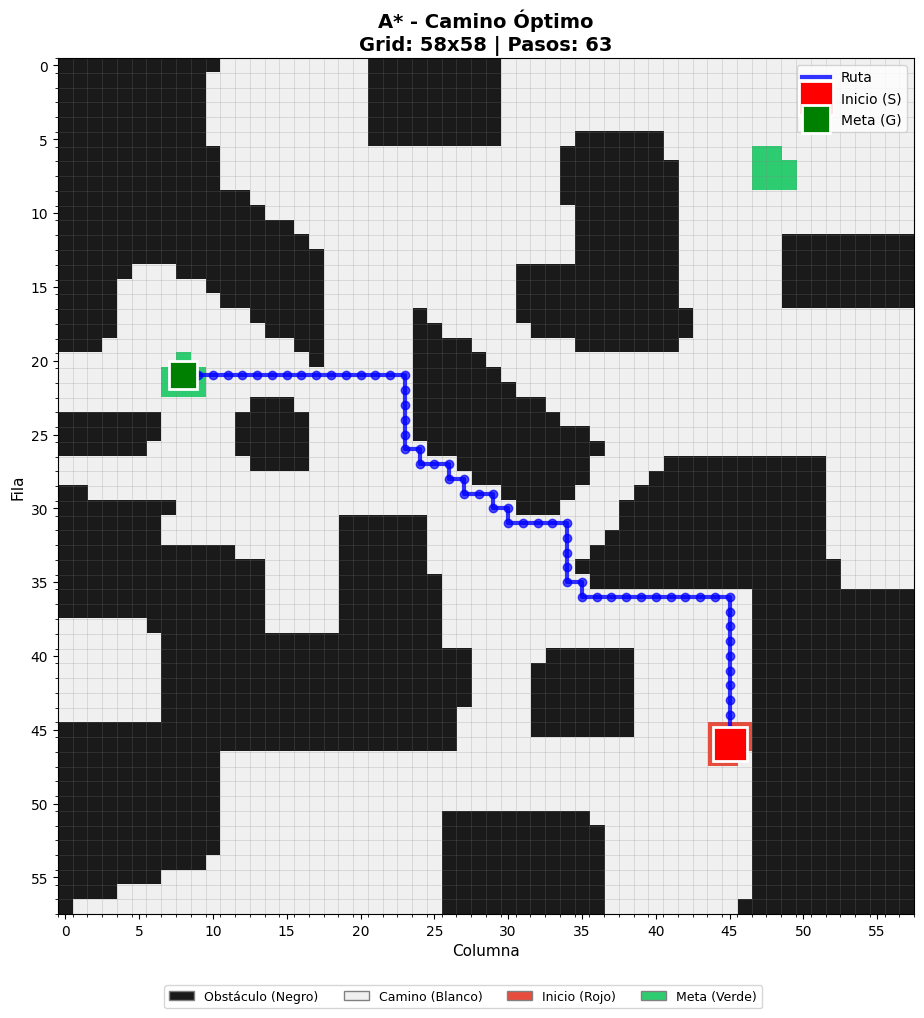


Inicio: Inicio: (46, 45)
Meta: Meta: (21, 8)
Longitud: Longitud del camino: 63 pasos


In [81]:
# Visualizar el camino A* en la matriz discreta
visualize_path_discrete(world, astar_path, title="A* - Camino Óptimo")

### 1.3.4 Comparación: BFS vs DFS vs A*

Comparamos los tres algoritmos en el mismo laberinto para ver la diferencia en eficiencia.

[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (46, 45)
  • Metas: [(7, 48), (21, 8)]

  BFS - Búsqueda en Anchura
  [OK] Solución encontrada
    • Longitud del camino: 63 pasos
    • Nodos expandidos: 1348
    • Nodos generados: 4967

  DFS - Búsqueda en Profundidad
  [OK] Solución encontrada
    • Longitud del camino: 221 pasos
    • Nodos expandidos: 568
    • Nodos generados: 2045

  A* - Búsqueda A-Star
  [OK] Solución encontrada
    • Longitud del camino: 63 pasos
    • Costo total: 62
    • Nodos expandidos: 451
    • Nodos generados: 1677


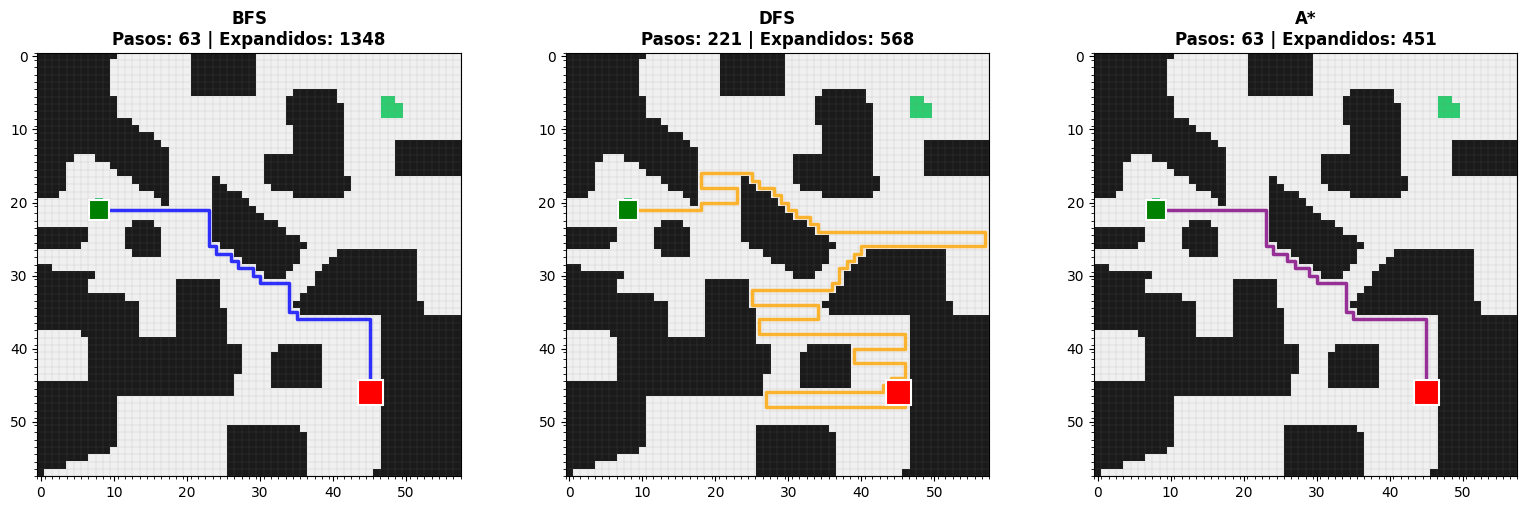


  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*
  Métrica                   BFS             DFS             A*             
  -----------------------------------------------------------------
  Longitud del camino       63              221             63             
  Costo del camino          62              220             62             
  Nodos expandidos          1348            568             451            
  Nodos generados           4967            2045            1677           
  -----------------------------------------------------------------
  Camino óptimo             Sí              No              Sí             
  Usa heurística            No              No              Sí             


In [82]:
# Comparar los tres algoritmos
results = compare_all_algorithms(world)


### 1.3.5 Pruebas con Todas las Imágenes Disponibles



  PROCESANDO: Test2.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test2.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=42, col=42)
  [INFO] Se encontraron 2 grupos de GOAL:
    Grupo 1: 14 tiles → centroide en (7, 22)
    Grupo 2: 14 tiles → centroide en (36, 2)
  [OK] 2 meta(s) encontrada(s):
      Meta 1: (row=7, col=22)
      Meta 2: (row=36, col=2)

  Distribución de terrenos:
    OBSTACLE (Negro): 1687 (50.1%)
    PATH (Blanco): 1638 (48.7%)
    START (Rojo): 11 (0.3%)
    GOAL (Verde): 28 (0.8%)

  RESUMEN
  • Grid size: 58 x 58
  • Total nodos: 3364
  • Nodos transitables: 1677
  • Inicio: (42, 42)
  • Metas: [(7, 22), (36, 2)]
[OK] MazeProblem inicializado
  • Grid: 58x58
  • Inicio: (42, 42)
  • Metas: [(7, 22), (36, 2)]

  BFS - Búsqueda en Anchura
  [OK] Solución encontrada
    • Longitud del camino: 56 pasos
    • Nodos

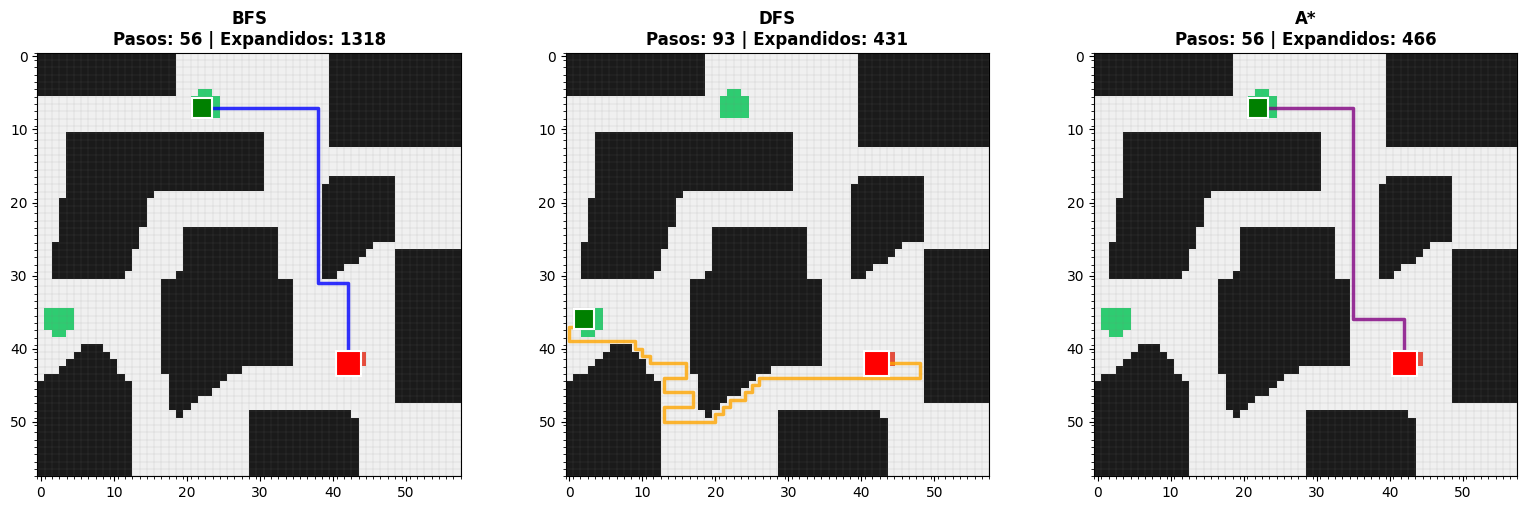


  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*
  Métrica                   BFS             DFS             A*             
  -----------------------------------------------------------------
  Longitud del camino       56              93              56             
  Costo del camino          55              92              55             
  Nodos expandidos          1318            431             466            
  Nodos generados           4900            1574            1773           
  -----------------------------------------------------------------
  Camino óptimo             Sí              No              Sí             
  Usa heurística            No              No              Sí             

  PROCESANDO: Prueba Lab1.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Prueba Lab1.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (r

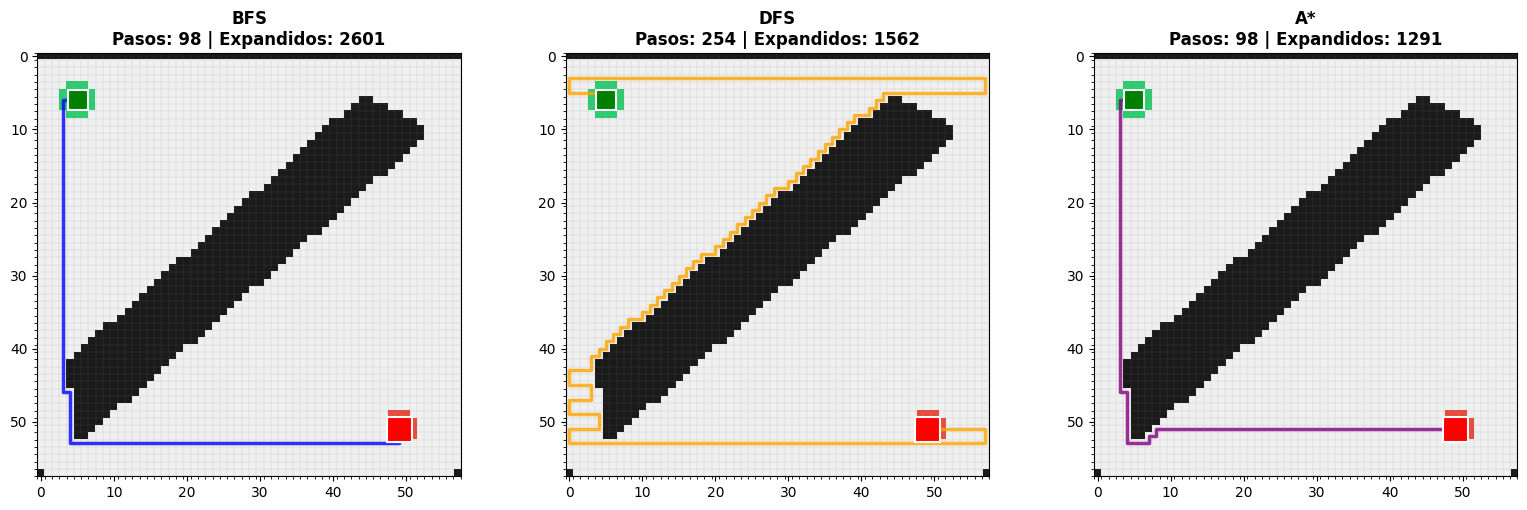


  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*
  Métrica                   BFS             DFS             A*             
  -----------------------------------------------------------------
  Longitud del camino       98              254             98             
  Costo del camino          97              253             97             
  Nodos expandidos          2601            1562            1291           
  Nodos generados           10006           5936            5047           
  -----------------------------------------------------------------
  Camino óptimo             Sí              No              Sí             
  Usa heurística            No              No              Sí             

  PROCESANDO: turing.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/turing.bmp
  Dimensiones: 640 x 640 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 5x5 píxeles
  Dimensiones del grid: 128x128 tiles
  [OK] Inicio encontrado en: (row=87, col

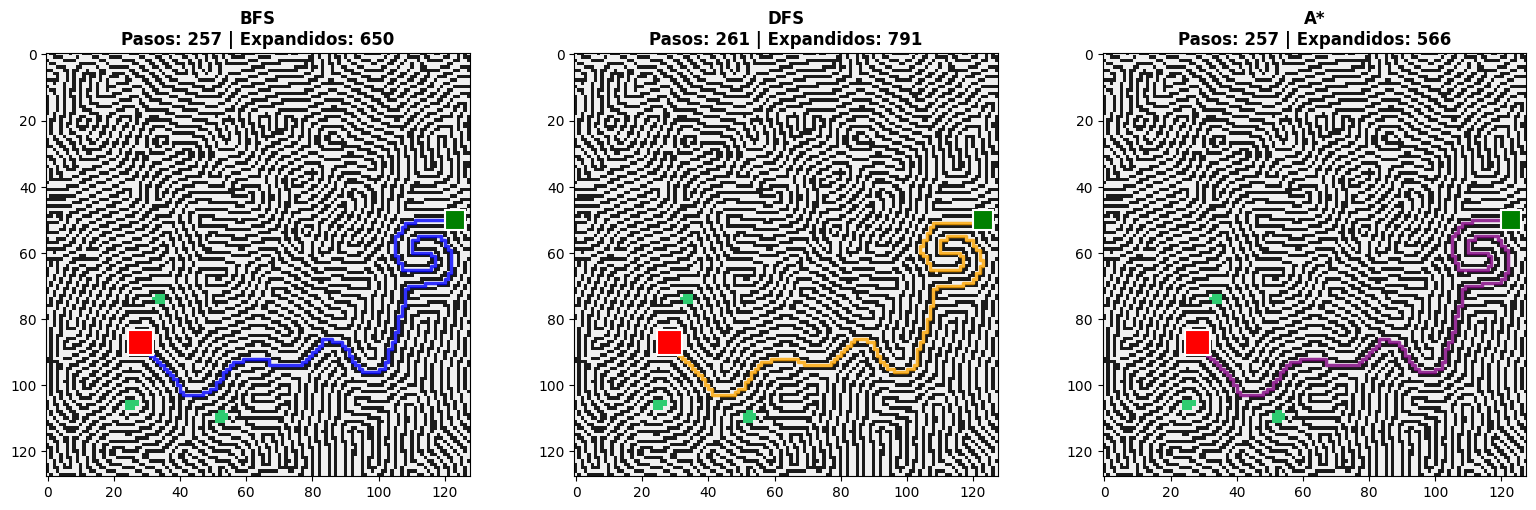


  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*
  Métrica                   BFS             DFS             A*             
  -----------------------------------------------------------------
  Longitud del camino       257             261             257            
  Costo del camino          256             260             256            
  Nodos expandidos          650             791             566            
  Nodos generados           1479            1800            1303           
  -----------------------------------------------------------------
  Camino óptimo             Sí              No              Sí             
  Usa heurística            No              No              Sí             

  PROCESANDO: Test.bmp
  DISCRETIZACIÓN DEL MUNDO - Task 1.1
[OK] Imagen cargada: img/Test.bmp
  Dimensiones: 582 x 582 píxeles
  Canales: 3

[OK] Discretizando imagen...
  Tamaño de tile: 10x10 píxeles
  Dimensiones del grid: 58x58 tiles
  [OK] Inicio encontrado en: (row=46, col=45)

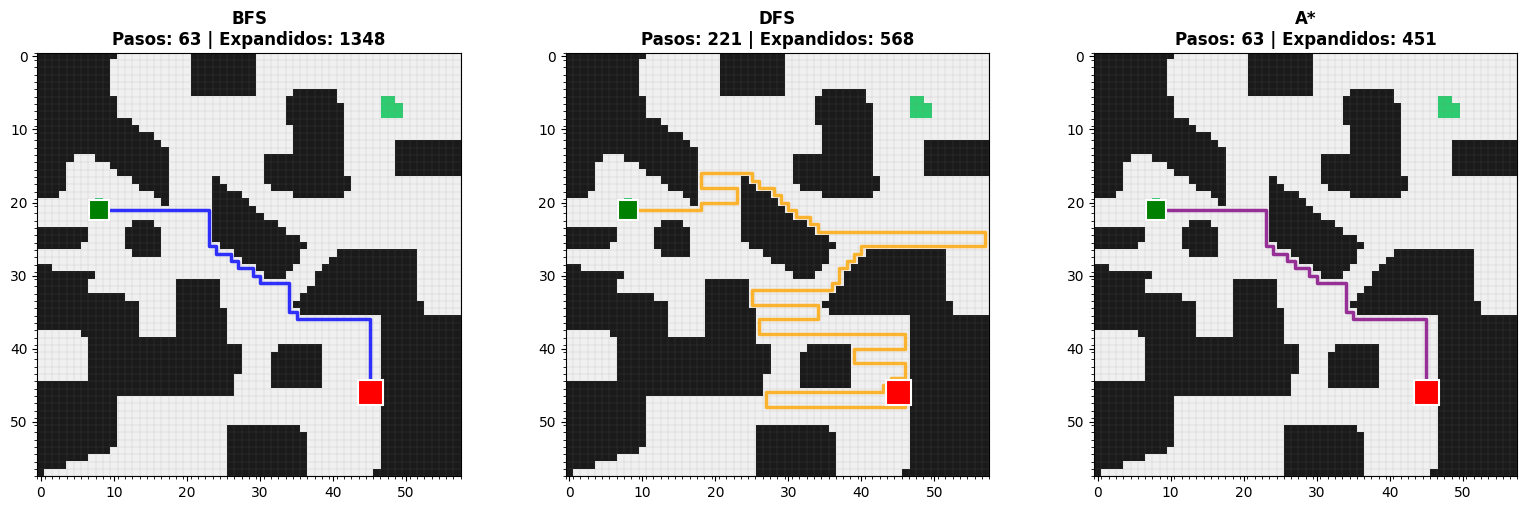


  COMPARACIÓN DE ALGORITMOS: BFS vs DFS vs A*
  Métrica                   BFS             DFS             A*             
  -----------------------------------------------------------------
  Longitud del camino       63              221             63             
  Costo del camino          62              220             62             
  Nodos expandidos          1348            568             451            
  Nodos generados           4967            2045            1677           
  -----------------------------------------------------------------
  Camino óptimo             Sí              No              Sí             
  Usa heurística            No              No              Sí             


In [84]:
def test_all_images(img_folder="img"):
    """
    Ejecuta los tres algoritmos (BFS, DFS, A*) en todas las imágenes disponibles.
    
    Args:
        img_folder (str): Carpeta con las imágenes
        
    Returns:
        dict: Resultados para cada imagen
    """
    all_results = {}
    images = [f for f in os.listdir(img_folder) if f.endswith(('.png', '.bmp', '.jpg'))]
    
    for img_name in images:
        img_path = os.path.join(img_folder, img_name)
        
        print("\n" + "="*70)
        print(f"  PROCESANDO: {img_name}")
        print("="*70)
        
        try:
            # Determinar tile_size apropiado según el tamaño y tipo de imagen
            with Image.open(img_path) as im:
                max_dim = max(im.size)
                # turing.bmp tiene patrones orgánicos que requieren tiles más pequeños
                if 'turing' in img_name.lower():
                    tile_size = 5
                elif max_dim > 1000:
                    tile_size = 20
                elif max_dim > 500:
                    tile_size = 10
                else:
                    tile_size = 5
            
            # Discretizar la imagen
            discretizer = process_maze_image(img_path, tile_size=tile_size, visualize=False)
            
            # Ejecutar comparación de algoritmos
            results = compare_all_algorithms(discretizer)
            
            all_results[img_name] = {
                'discretizer': discretizer,
                'results': results,
                'success': True
            }
            
        except Exception as e:
            print(f"  [X] Error procesando {img_name}: {e}")
            all_results[img_name] = {
                'success': False,
                'error': str(e)
            }
    
    return all_results

# Ejecutar pruebas con todas las imágenes
all_test_results = test_all_images()

### Resumen de Resultados

Tabla comparativa de los resultados obtenidos en todas las imágenes.

In [107]:
# Generar tabla resumen de todos los resultados
print("\n" + "="*90)
print("  RESUMEN FINAL: COMPARACIÓN DE ALGORITMOS EN TODAS LAS IMÁGENES")
print("="*90)

# Encabezado
print(f"\n{'Imagen':<20} {'Algoritmo':<10} {'Pasos':<10} {'Costo':<10} {'Expandidos':<12} {'Generados':<12}")
print("-"*90)

for img_name, data in all_test_results.items():
    if data['success']:
        results = data['results']
        
        for algo_name, (path, stats) in results.items():
            pasos = len(path) if path else 'N/A'
            costo = stats['path_cost'] if stats['solution_found'] else 'N/A'
            expandidos = stats['nodes_expanded']
            generados = stats['nodes_generated']
            
            # Solo mostrar nombre de imagen en la primera línea
            img_display = img_name if algo_name == 'bfs' else ''
            
            print(f"{img_display:<20} {algo_name.upper():<10} {str(pasos):<10} {str(costo):<10} {expandidos:<12} {generados:<12}")
        
        print("-"*90)
    else:
        print(f"{img_name:<20} ERROR: {data['error']}")
        print("-"*90)

print("\n[OK] Pruebas completadas")


  RESUMEN FINAL: COMPARACIÓN DE ALGORITMOS EN TODAS LAS IMÁGENES

Imagen               Algoritmo  Pasos      Costo      Expandidos   Generados   
------------------------------------------------------------------------------------------
Test2.bmp            BFS        56         55         1318         4900        
                     DFS        93         92         431          1574        
                     ASTAR      56         55         466          1773        
------------------------------------------------------------------------------------------
Prueba Lab1.bmp      BFS        98         97         2601         10006       
                     DFS        254        253        1562         5936        
                     ASTAR      98         97         1291         5047        
------------------------------------------------------------------------------------------
turing.bmp           BFS        257        256        650          1479        
                    

---

## Notas de Implementación

### Decisiones de Diseño - Task 1.1

1. **Tamaño de Tile**: Se utiliza un tamaño configurable (por defecto 10x10 píxeles) para balancear precisión y eficiencia.

2. **Clasificación de Tiles**: 
   - Se usa un sistema de prioridad: Inicio > Meta > Obstáculo > Camino
   - Esto asegura que no se pierdan puntos críticos del laberinto

3. **Umbral de Obstáculos**: Un tile se considera obstáculo si más del 50% de sus píxeles son negros.

4. **Flexibilidad de Colores**: Los umbrales de color son configurables para adaptarse a diferentes imágenes.

### Decisiones de Diseño - Task 1.2

1. **Clase Abstracta SearchProblem**: Define la interfaz formal del problema de búsqueda siguiendo el framework estándar (initial_state, goal_test, actions, result, step_cost).

2. **Clase Node**: Encapsula un estado junto con información del camino (padre, acción, costo acumulado, profundidad).

3. **GraphSearch Genérico**: Implementa el algoritmo de búsqueda en grafos donde la estructura de la frontera determina el comportamiento:
   - Cola (FIFO) → BFS: Encuentra el camino más corto en número de pasos
   - Pila (LIFO) → DFS: Explora rápidamente pero no garantiza optimalidad

4. **Movimientos**: Se permiten 4 direcciones (UP, DOWN, LEFT, RIGHT) sin movimientos diagonales.

5. **Costo Uniforme**: Para Task 1.2, todos los movimientos tienen costo 1 (se modificará en Task 2).

### Decisiones de Diseño - Task 1.3

1. **Algoritmo A***: Combina costo real g(n) con heurística h(n) para búsqueda informada óptima.

2. **Heurística Manhattan**: Distancia Manhattan al goal más cercano. Es admisible y consistente.

3. **Cola de Prioridad**: Usa `heapq` para extraer siempre el nodo con menor f(n) = g(n) + h(n).

4. **Eficiencia**: A* expande menos nodos que BFS gracias a la guía heurística, manteniendo optimalidad.
